# Market Insights Analysis

## Libraries Importing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import os
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster, cut_tree
from scipy.spatial.distance import pdist
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
from sklearn.metrics import silhouette_score

from datetime import timedelta
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_calibration_purchases_vs_holdout_purchases

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from yellowbrick.cluster import KElbowVisualizer


import s3fs
import json
from sklearn.metrics.pairwise import cosine_similarity
import datetime as dt

from xgboost import XGBClassifier

import imblearn

import warnings
warnings.filterwarnings('ignore')


## Data Importing

In [2]:
sales = pd.read_csv('Data/sales_cleaned.csv')
products = pd.read_csv('Data/products.csv') # extract unique product ID/name/group from table 'sales'
products.set_index('Product_SKU', inplace=True)
marketing = pd.read_csv('Data/marketing_cleaned.csv')
customer = pd.read_csv('Data/CustomersData.csv')
coupon = pd.read_csv('Data/Discount_Coupon.csv')
tax = pd.read_csv('Data/Tax_amount.csv')
customer_analysis = pd.read_csv('Data/customer_analysis.csv')
product_analysis = pd.read_csv('Data/product_analysis.csv')

customer_analysis = customer_analysis.drop(customer_analysis.columns[0], axis=1)
sales = sales.drop(sales.columns[0], axis=1)

## Exploratory Data Analysis

### General Data Exploration

#### Revenue Boxplot

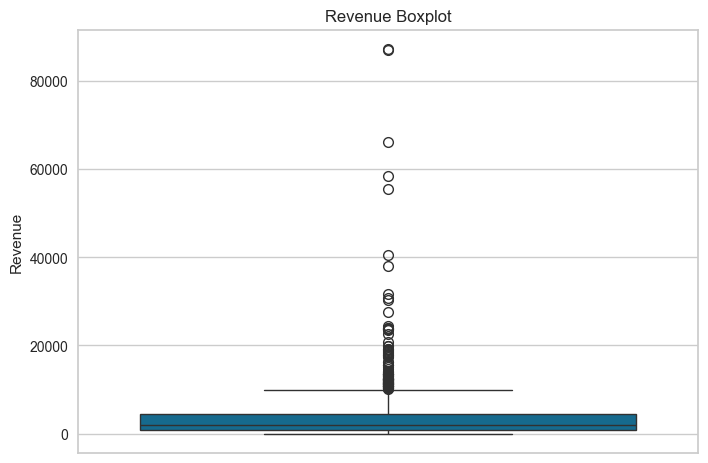

In [3]:
# Create boxplot of Revenue column from customer_analysis
sns.boxplot(data=customer_analysis, y='Revenue')
# Set title
plt.title('Revenue Boxplot');

#### Number of Customers vs. Revenue

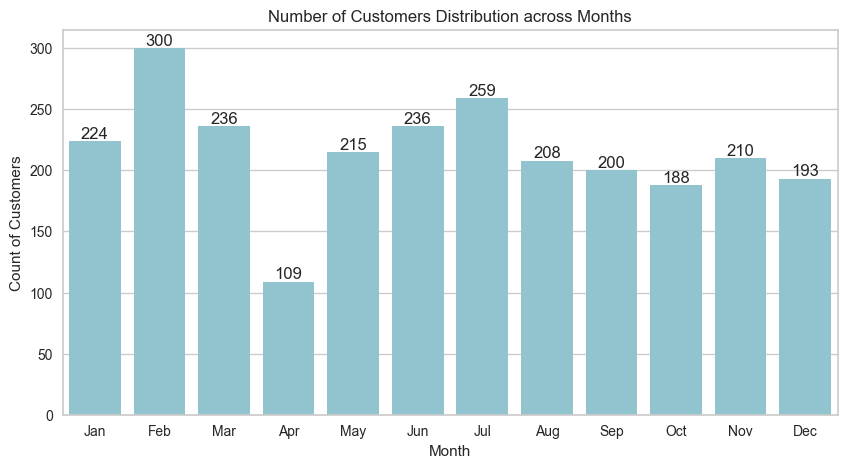

In [4]:
plt.figure(figsize=(10, 5))

count_customer = sales.groupby("Month")["CustomerID"].nunique()

ax1 = sns.barplot(x=count_customer.index, y=count_customer, color='c', errwidth=0)
ax1.set(xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Number of Customers Distribution across Months')
plt.ylabel('Count of Customers')
for i, val in enumerate(count_customer):
    ax1.text(i, val, f'{val}', ha='center', va='bottom')


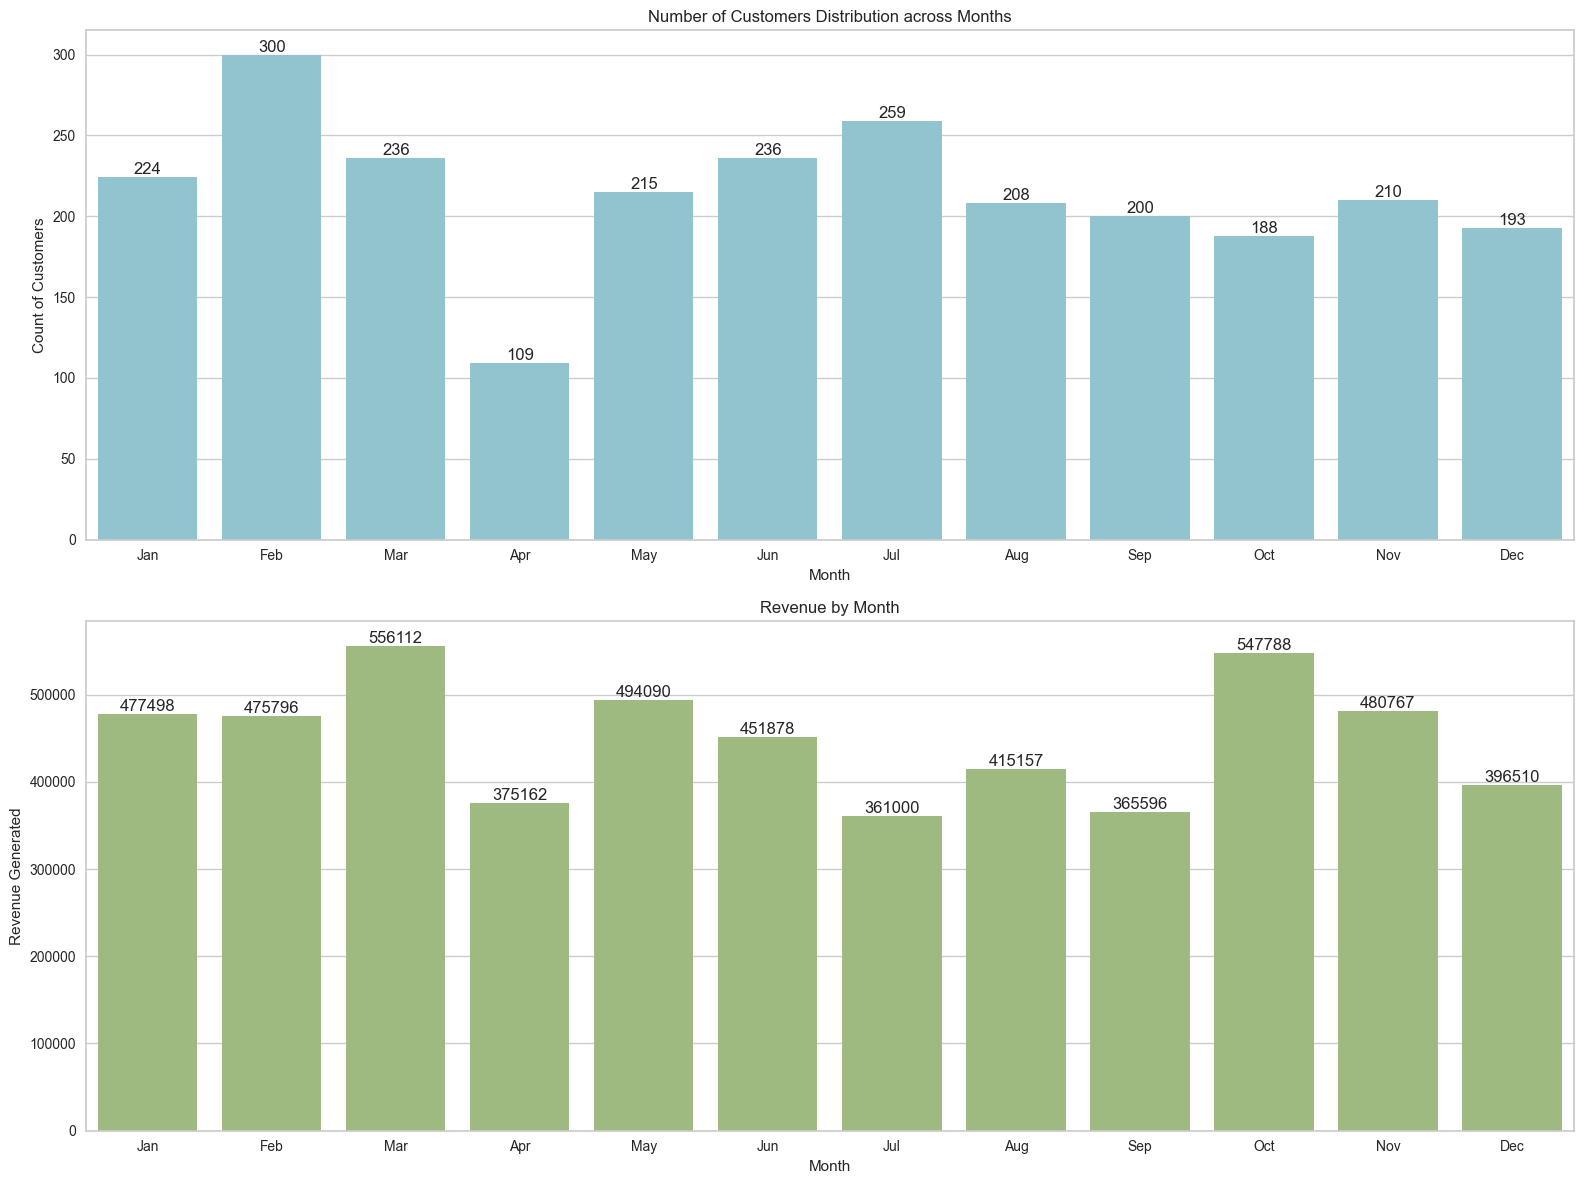

In [5]:
# Calculate the mean number of mosquitos for each month
count_customer = sales.groupby("Month")["CustomerID"].nunique()

# Grouping the 'sales' DataFrame by 'Month' and calculating the sum of 'Revenue' for each month, converting the result to integer type
revenue_count_by_month = sales.groupby('Month')['Revenue'].sum().astype(int)


# Set figure size
plt.figure(figsize=(16, 12))  # Adjust the figure size if needed

# Subplot1: for 'Number of Customers Distribution across Months'
plt.subplot(2, 1, 1)  # 2 rows, 1 column, subplot 1
ax1 = sns.barplot(x=count_customer.index, y=count_customer, color='c', errwidth=0)
ax1.set(xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Number of Customers Distribution across Months')
plt.ylabel('Count of Customers')
for i, val in enumerate(count_customer):
    ax1.text(i, val, f'{val}', ha='center', va='bottom')

# Subplot2: for 'Revenue by Month'
plt.subplot(2, 1, 2)  # 2 rows, 1 column, subplot 2
ax2 = sns.barplot(x=revenue_count_by_month.index, y=revenue_count_by_month, color='g', errwidth=0)
ax2.set(xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Revenue by Month')
plt.ylabel('Revenue Generated')
for i, val in enumerate(revenue_count_by_month):
    ax2.text(i, val, f'{val}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Number of Transactions vs. Revenue

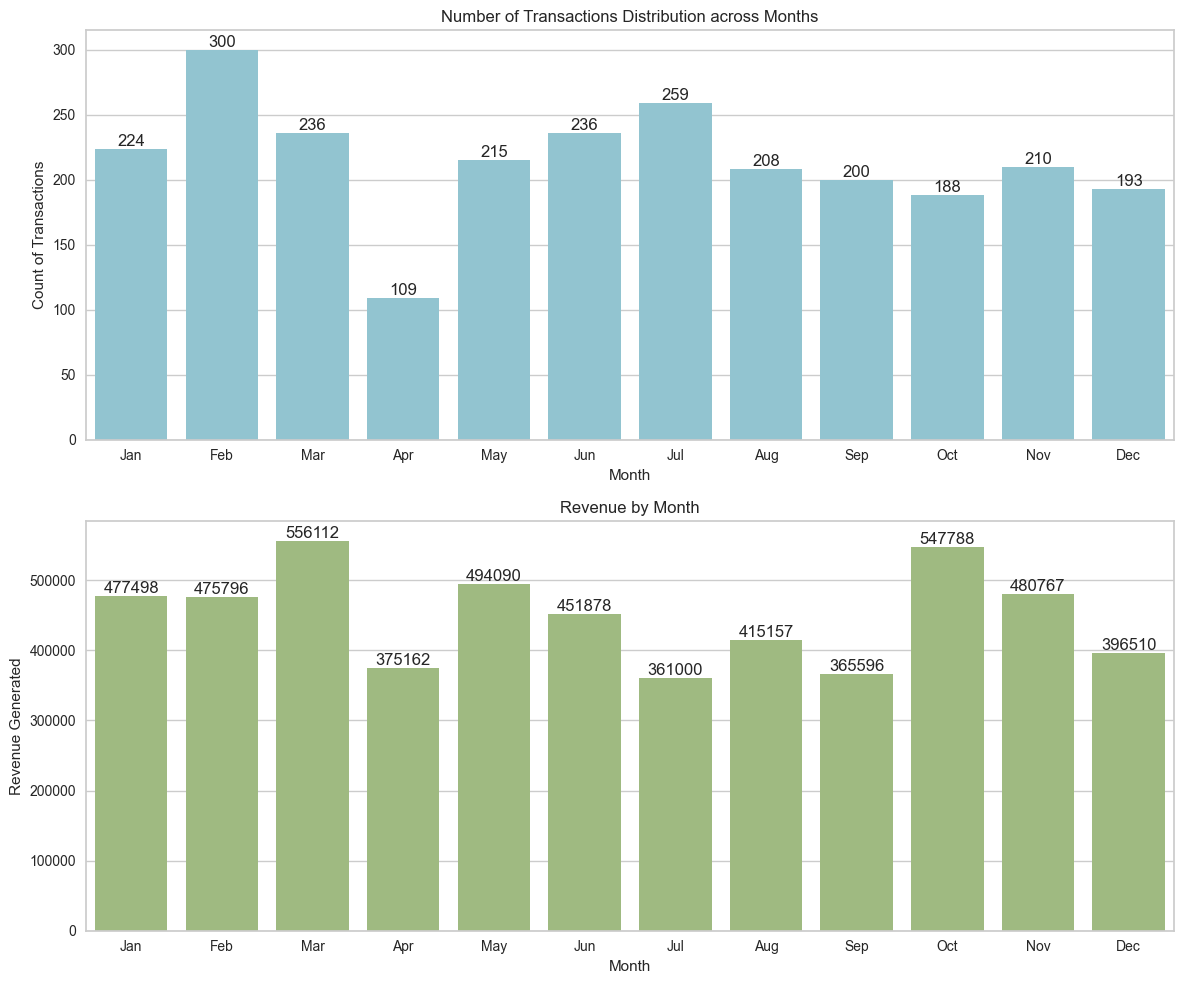

In [6]:
count_transaction = sales.groupby("Month")["CustomerID"].nunique()
revenue_count_by_month = sales.groupby('Month')['Revenue'].sum().astype(int)

# Set figure size
plt.figure(figsize=(12, 10))  # Adjust the figure size if needed

# Subplot1: for 'Number of Customers Distribution across Months'
plt.subplot(2, 1, 1)  # 2 rows, 1 column, subplot 1
ax1 = sns.barplot(x=count_transaction.index, y=count_transaction, color='c', errwidth=0)
ax1.set(xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Number of Transactions Distribution across Months')
plt.ylabel('Count of Transactions')
for i, val in enumerate(count_transaction):
    ax1.text(i, val, f'{val}', ha='center', va='bottom')

# Subplot2: for 'Revenue by Month'
plt.subplot(2, 1, 2)  # 2 rows, 1 column, subplot 2
ax2 = sns.barplot(x=revenue_count_by_month.index, y=revenue_count_by_month, color='g', errwidth=0)
ax2.set(xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Revenue by Month')
plt.ylabel('Revenue Generated')
for i, val in enumerate(revenue_count_by_month):
    ax2.text(i, val, f'{val}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Daily Transaction vs. Monthly Transaction

In [7]:
# Convert 'Transaction_Date' column to 'datetime64[ns]' format if it's not already in that format
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])

# Create a new column 'InvoiceMonthly' by converting 'Transaction_Date' to a monthly frequency period ('M')
# then converting it back to 'datetime64[ns]' format to represent the start date of each month
sales['InvoiceMonthly'] = sales['Transaction_Date'].dt.to_period('M').dt.to_timestamp('M')

# Create a new column 'InvoiceDaily' by converting 'Transaction_Date' to a daily frequency period ('D')
# then converting it back to 'datetime64[ns]' format to retain the transaction dates at the daily level
sales['InvoiceDaily'] = sales['Transaction_Date'].dt.to_period('D').dt.to_timestamp('D')


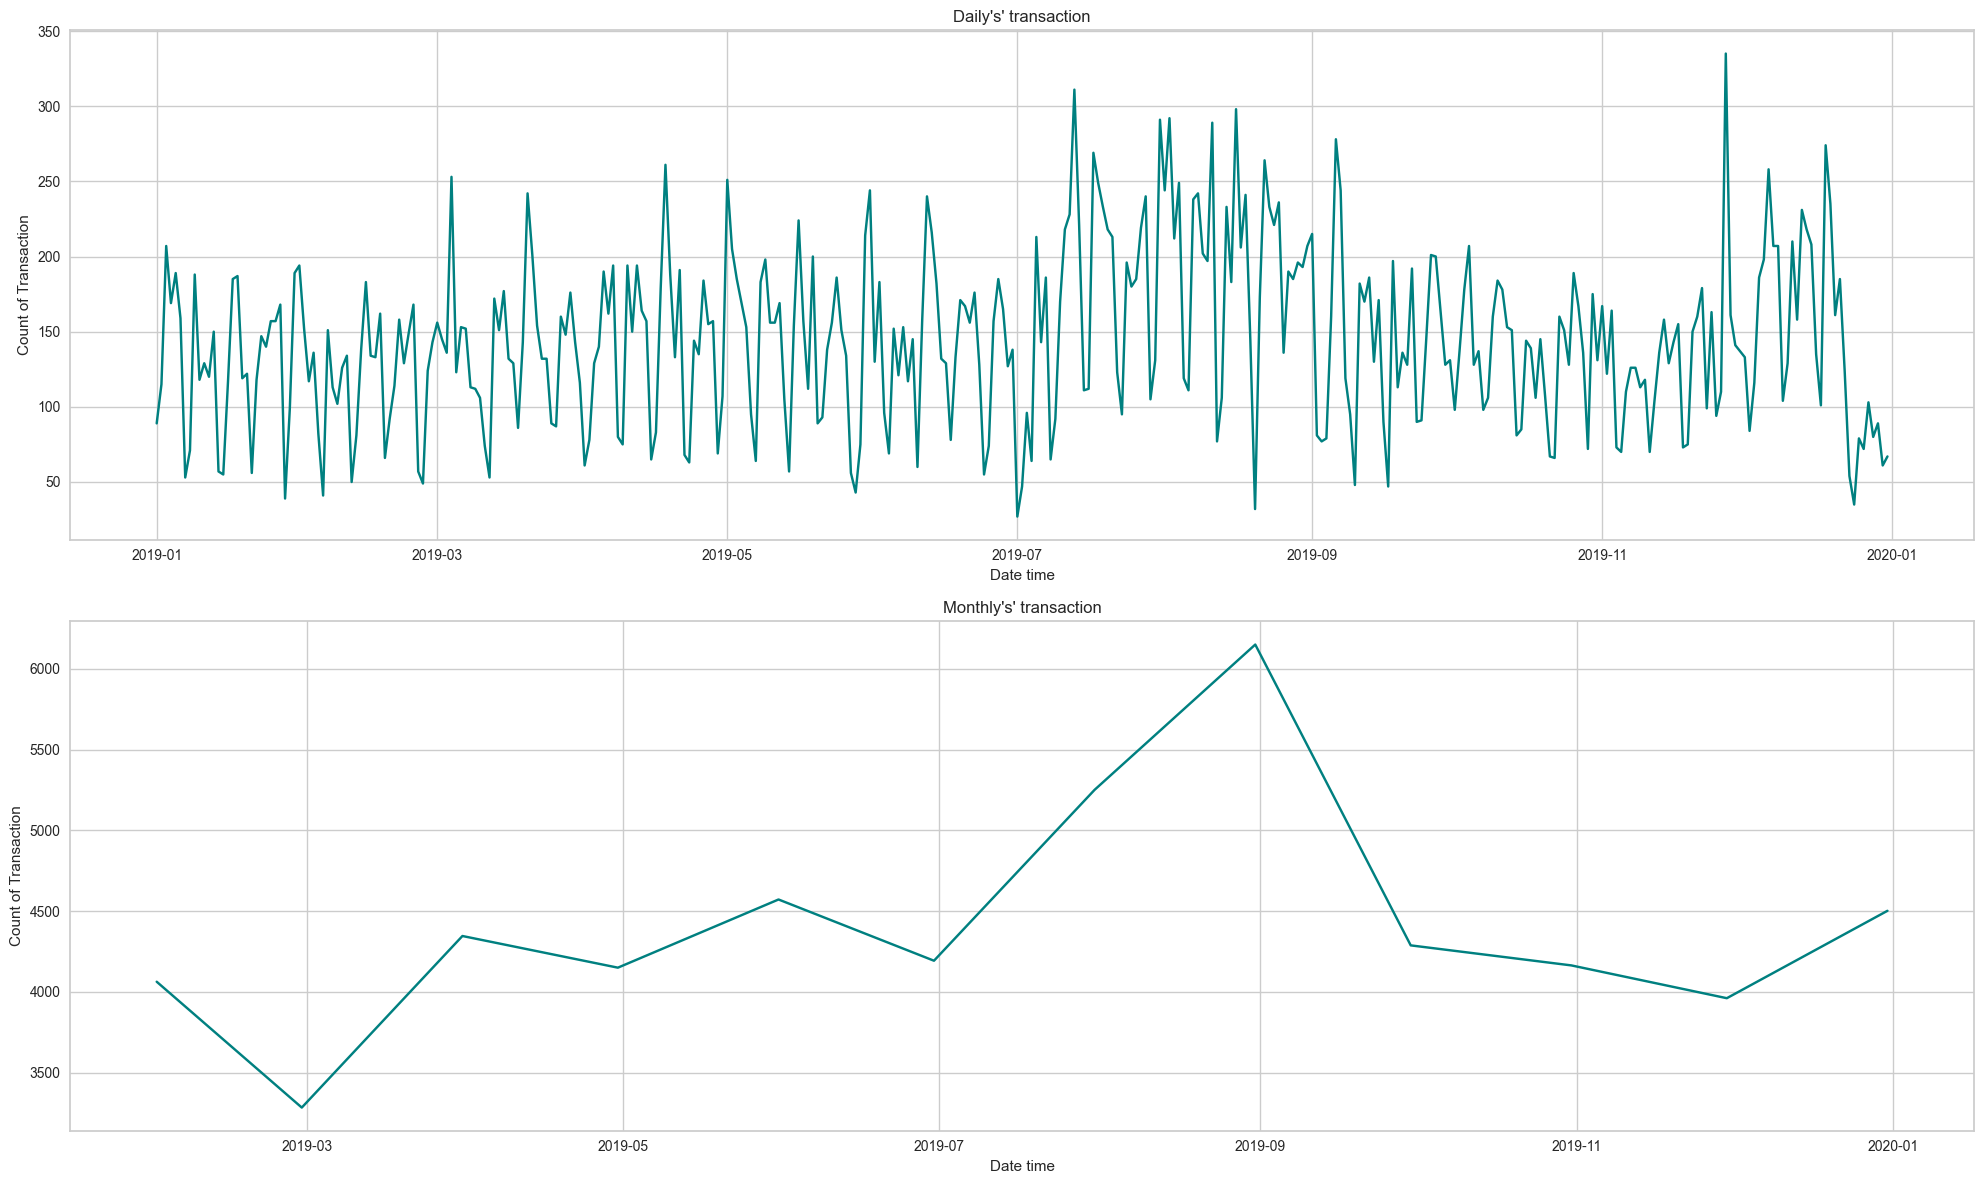

In [8]:
# Create a figure with a size of 20x12 inches to accommodate two subplots in two rows
plt.figure(figsize=(20, 12))

# Iterate through 'Daily' and 'Monthly' to create subplots for different time frequencies
for i, col in enumerate(['Daily', 'Monthly']):
    # Group the sales data by 'InvoiceDaily' or 'InvoiceMonthly' and count the number of transactions ('Revenue') for each date
    dataPlot = sales.groupby([f'Invoice{col}'])['Revenue'].count()

    # Create subplots in a 2x1 grid (2 rows, 1 column)
    plt.subplot(2, 1, i + 1)

    # Plot the data as a line plot
    plt.plot(
        dataPlot.index,  # X-axis: Index of the grouped date
        dataPlot,  # Y-axis: Count of transactions
        c='teal'  # Color of the line plot
    )

    # Set subplot title based on the time frequency ('Daily' or 'Monthly')
    plt.title(f"{col}'s' transaction")

    # Set labels for the x-axis and y-axis
    plt.xlabel('Date time')
    plt.ylabel('Count of Transaction')

# Adjust layout spacing
plt.tight_layout()

# Display the plots
plt.show()


#### Relationship between Count of Customers vs. Revenue

In [9]:
# Grouping the 'sales' DataFrame by 'Month' and calculating the number of unique customers ('CustomerID') for each month
customer = sales.groupby('Month')['CustomerID'].nunique().reset_index()

# Grouping the 'sales' DataFrame by 'Month' and summing up the 'Revenue' for each month
revenue = sales.groupby('Month')['Revenue'].sum().reset_index()

# Merging the 'customer' and 'revenue' DataFrames on the 'Month' column using inner join
result = customer.merge(revenue, on='Month', how='inner')

# Renaming the 'CustomerID' column to 'Total_Customers' for better readability
result = result.rename(columns={'CustomerID': 'Total_Customers'})


In [10]:
# Grouping the 'sales' DataFrame by 'Month' and calculating the number of unique customers ('CustomerID') for each month
transaction = sales.groupby('Month')['Transaction_ID'].nunique().reset_index()

# Grouping the 'sales' DataFrame by 'Month' and summing up the 'Revenue' for each month
revenue = sales.groupby('Month')['Revenue'].sum().reset_index()

# Merging the 'customer' and 'revenue' DataFrames on the 'Month' column using inner join
result2 = transaction.merge(revenue, on='Month', how='inner')

# Renaming the 'CustomerID' column to 'Total_Customers' for better readability
result2 = result2.rename(columns={'Transaction_ID': 'Total_Transactions'})


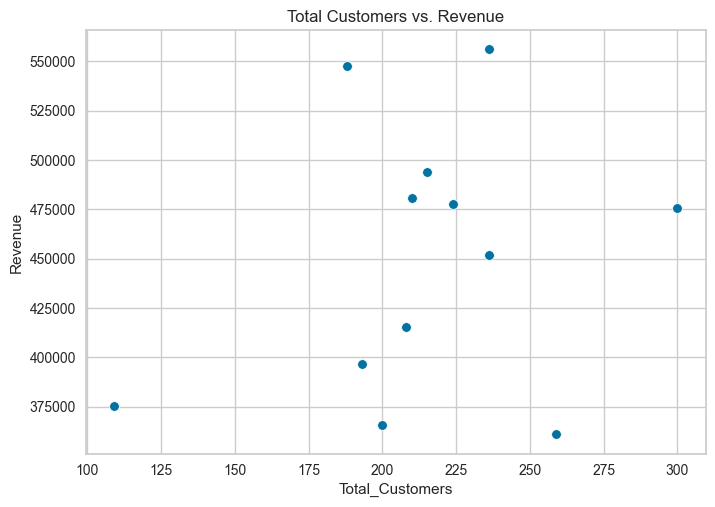

In [11]:
# Create a scatter plot using Seaborn's scatterplot function to depict the relationship between 'Total_Customers' and 'Revenue'
sns.scatterplot(data=result, x='Total_Customers', y='Revenue')

# Set the title of the plot
plt.title('Total Customers vs. Revenue');


In [12]:
sales.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status', 'Gender', 'Location',
       'Tenure_Months', 'Month', 'InvoiceMonthly', 'InvoiceDaily',
       'Coupon_Code', 'Discount_pct', 'GST', 'Revenue', 'Product_Group'],
      dtype='object')

In [13]:
customer_analysis.columns

Index(['CustomerID', 'Total_Spending', 'Delivery_Charges', 'Num_Transactions',
       'Total_Quantity', 'Location', 'Gender', 'Tenure_Months',
       'Used_Coupon_Count', 'Not_Use_Coupon_Count', 'Clicked_Coupon_Count',
       'Revenue'],
      dtype='object')

<Axes: xlabel='Total_Spending', ylabel='Total_Quantity'>

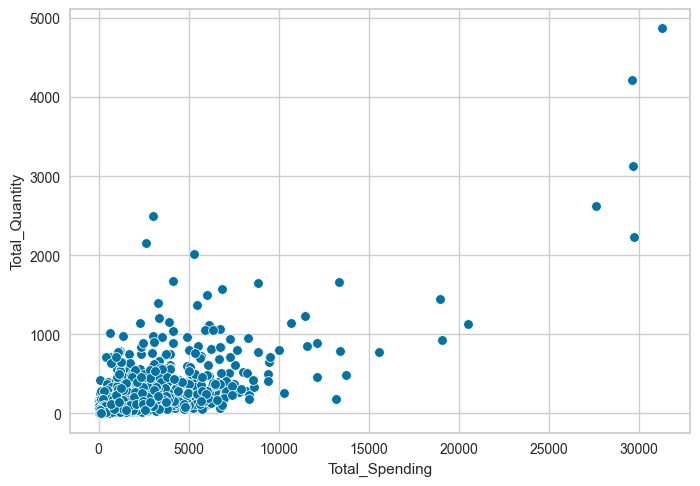

In [14]:
sns.scatterplot(x='Total_Spending', y='Total_Quantity', data=customer_analysis)

<Axes: xlabel='Total_Spending', ylabel='Delivery_Charges'>

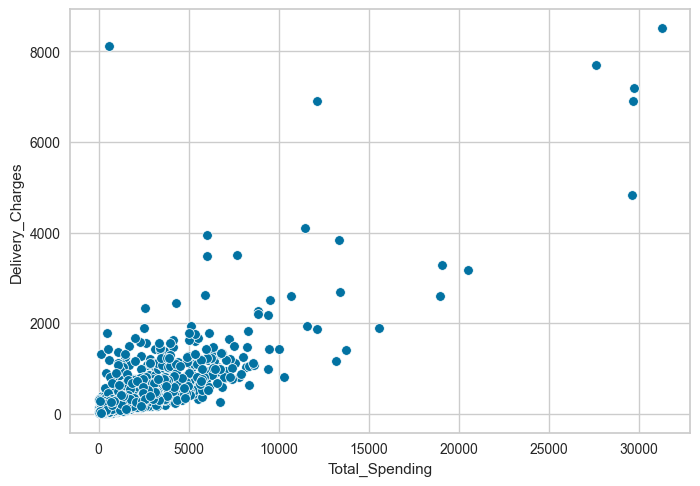

In [15]:
sns.scatterplot(x='Total_Spending', y='Delivery_Charges', data=customer_analysis)

<Axes: xlabel='Total_Quantity', ylabel='Used_Coupon_Count'>

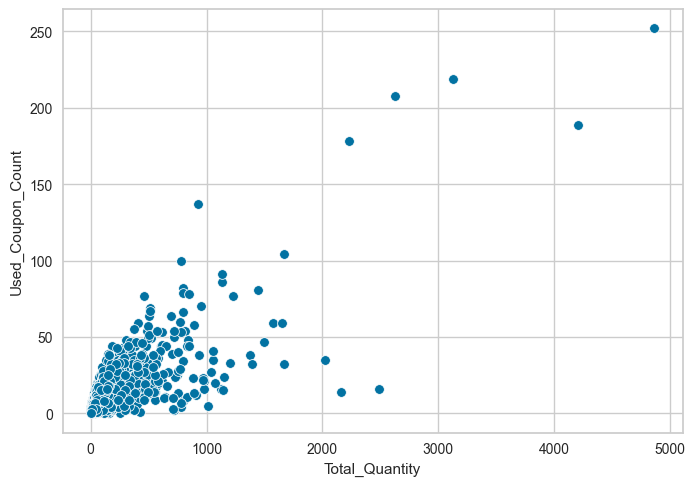

In [16]:
sns.scatterplot(x='Total_Quantity', y='Used_Coupon_Count', data=customer_analysis)

In [17]:
customer_analysis.columns

Index(['CustomerID', 'Total_Spending', 'Delivery_Charges', 'Num_Transactions',
       'Total_Quantity', 'Location', 'Gender', 'Tenure_Months',
       'Used_Coupon_Count', 'Not_Use_Coupon_Count', 'Clicked_Coupon_Count',
       'Revenue'],
      dtype='object')

#### Relationship between Count of Transactions vs. Revenue

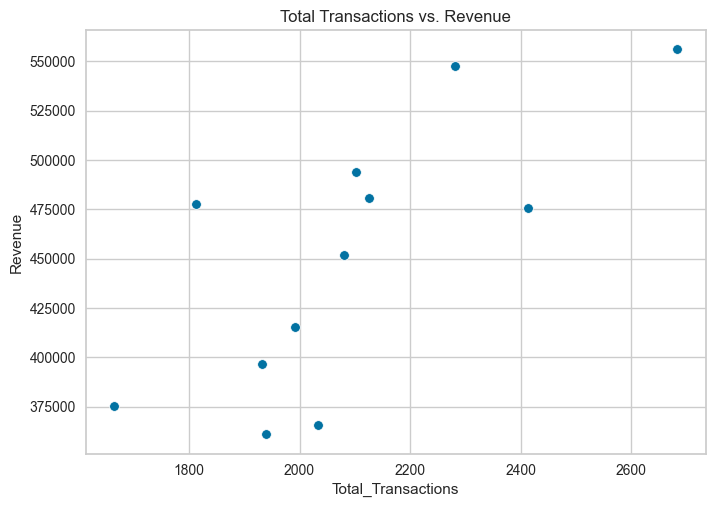

In [18]:
# Create a scatter plot using Seaborn's scatterplot function to depict the relationship between 'Total_Customers' and 'Revenue'
sns.scatterplot(data=result2, x='Total_Transactions', y='Revenue')

# Set the title of the plot
plt.title('Total Transactions vs. Revenue');


In [19]:
# Correlation of total customers and revenue
corr = result['Total_Customers'].corr(result['Revenue'])
corr

0.25517575682063454

In [20]:
# Correlation of total customers and revenue
corr = result2['Total_Transactions'].corr(result2['Revenue'])
corr

0.7243438530580788

#### Product's Quantity Distribution

In [21]:
# Group Sum Quantity by Product SKU
category_quantity = sales.groupby('Product_SKU')['Quantity'].sum()

# Find the top 10 category with the highest total quantity
top_10_categories = category_quantity.sort_values(ascending=False).head(10)
top_10_categories

Product_SKU
GGOEGGOA017399    16234
GGOEGDHC018299     9728
GGOEGBMJ013399     7321
GGOEGOLC014299     6496
GGOEGFKQ020399     5847
GGOEGFSR022099     5549
GGOENEBQ078999     5206
GGOEGFYQ016599     5098
GGOEGOAQ012899     4861
GGOENEBJ079499     4570
Name: Quantity, dtype: int64

In [22]:
# Group Sum Quantity by Product SKU
group_prodid_quant = sales.groupby('Product_SKU')['Quantity'].sum()

# Find the top 10 category with the highest total quantity
product_quant = group_prodid_quant.sort_values(ascending=False)


In [23]:
# Resetting the index of the DataFrame 'top_10_categories' and storing the result in a new DataFrame 'top10'
top10 = top_10_categories.reset_index()
top10

,Product_SKU,Quantity
0,GGOEGGOA017399,16234
1,GGOEGDHC018299,9728
2,GGOEGBMJ013399,7321
3,GGOEGOLC014299,6496
4,GGOEGFKQ020399,5847
5,GGOEGFSR022099,5549
6,GGOENEBQ078999,5206
7,GGOEGFYQ016599,5098
8,GGOEGOAQ012899,4861
9,GGOENEBJ079499,4570


In [24]:
product_quantity = product_quant.reset_index()

In [25]:
# Filtering the 'sales' DataFrame based on whether the 'Product_SKU' values are present in the 'top10' DataFrame
top10_df = sales[sales['Product_SKU'].isin(top10['Product_SKU'])]
top10_df.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Location,Tenure_Months,Month,InvoiceMonthly,InvoiceDaily,Coupon_Code,Discount_pct,GST,Revenue,Product_Group
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest,1,153.71,6.5,Used,...,Chicago,12,Jan,2019-01-31,2019-01-01,ELEC10,10.0,0.10,158.6729,Google
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest,1,153.71,6.5,Used,...,Chicago,12,Jan,2019-01-31,2019-01-01,ELEC10,10.0,0.10,158.6729,Google
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,...,Chicago,12,Jan,2019-01-31,2019-01-01,OFF10,10.0,0.10,8.5295,Google
5,17850,16682,2019-01-01,GGOEGBMJ013399,Sport Bag,Bags,15,5.15,6.5,Used,...,Chicago,12,Jan,2019-01-31,2019-01-01,AIO10,10.0,0.18,88.5395,No-Brand
6,17850,16682,2019-01-01,GGOEGDHC018299,Google 22 oz Water Bottle,Drinkware,15,3.08,6.5,Not Used,...,Chicago,12,Jan,2019-01-31,2019-01-01,EXTRA10,10.0,0.18,61.0160,Google


In [26]:
# Filtering the 'sales' DataFrame based on whether the 'Product_SKU' values are present in the 'top10' DataFrame
sku = sales[sales['Product_SKU'].isin(product_quantity['Product_SKU'])]
sku.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Location,Tenure_Months,Month,InvoiceMonthly,InvoiceDaily,Coupon_Code,Discount_pct,GST,Revenue,Product_Group
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest,1,153.71,6.5,Used,...,Chicago,12,Jan,2019-01-31,2019-01-01,ELEC10,10.0,0.10,158.6729,Google
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest,1,153.71,6.5,Used,...,Chicago,12,Jan,2019-01-31,2019-01-01,ELEC10,10.0,0.10,158.6729,Google
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,...,Chicago,12,Jan,2019-01-31,2019-01-01,OFF10,10.0,0.10,8.5295,Google
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,...,Chicago,12,Jan,2019-01-31,2019-01-01,SALE10,10.0,0.18,109.9270,Google
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,...,Chicago,12,Jan,2019-01-31,2019-01-01,AIO10,10.0,0.18,24.0230,Google


In [27]:
# Grouping the 'top10_df' DataFrame by 'Product_SKU' and aggregating various columns
top10_df = top10_df.groupby('Product_SKU').agg({
    'Product_Description': 'first',  # Take the first value of 'Product_Description'
    'Product_Category': 'first',     # Take the first value of 'Product_Category'
    'Product_Group': 'first',        # Take the first value of 'Product_Category'
    'Quantity': 'sum',               # Summing the 'Quantity' values
    'Revenue': 'sum'                 # Summing the 'Revenue' values
}).reset_index()

# Renaming the columns in the 'top10_df' DataFrame for better readability
top10_df.columns = ['Product ID', 'Product Description', 'Product Category', 'Product Group', 'Quantity', 'Revenue']

# Display the summary statistics DataFrame
top10_df

,Product ID,Product Description,Product Category,Product Group,Quantity,Revenue
0,GGOEGBMJ013399,Sport Bag,Bags,No-Brand,7321,42068.25962
1,GGOEGDHC018299,Google 22 oz Water Bottle,Drinkware,Google,9728,37418.94532
2,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,Google,5847,24533.63450
3,GGOEGFSR022099,Google Kick Ball,Lifestyle,Google,5549,15676.89884
4,GGOEGFYQ016599,Foam Can and Bottle Cooler,Drinkware,No-Brand,5098,11559.08054
5,GGOEGGOA017399,Maze Pen,Office,No-Brand,16234,19786.07210
6,GGOEGOAQ012899,Ballpoint LED Light Pen,Office,No-Brand,4861,15697.98510
7,GGOEGOLC014299,Google Metallic Notebook Set,Office,Google,6496,41481.37750
8,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest,Google,4570,731870.69120
9,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest,Google,5206,671620.06650


In [28]:
# Grouping the 'top10_df' DataFrame by 'Product_SKU' and aggregating various columns
sku = sku.groupby('Product_SKU').agg({
    'Product_Description': 'first',  # Take the first value of 'Product_Description'
    'Product_Category': 'first',     # Take the first value of 'Product_Category'
    'Product_Group': 'first',        # Take the first value of 'Product_Category'
    'Quantity': 'sum',               # Summing the 'Quantity' values
    'Revenue': 'sum'                 # Summing the 'Revenue' values
}).reset_index()

# Renaming the columns in the 'top10_df' DataFrame for better readability
sku.columns = ['Product ID', 'Product Description', 'Product Category', 'Product Group', 'Quantity', 'Revenue']

# Display the summary statistics DataFrame
sku.head()

,Product ID,Product Description,Product Category,Product Group,Quantity,Revenue
0,GGOEA0CH077599,Android Hard Cover Journal,Notebooks & Journals,Android,515,7929.94495
1,GGOEAAAB034813,Android BTTF Cosmos Graphic Tee,Apparel,Android,22,464.43500
2,GGOEAAAB034814,Android BTTF Cosmos Graphic Tee,Apparel,Android,57,951.88288
3,GGOEAAAB034815,Android BTTF Cosmos Graphic Tee,Apparel,Android,41,1072.71678
4,GGOEAAAB034816,Android BTTF Cosmos Graphic Tee,Apparel,Android,24,620.99992


#### Top 10 Purchased Products by Revenue and Quantity

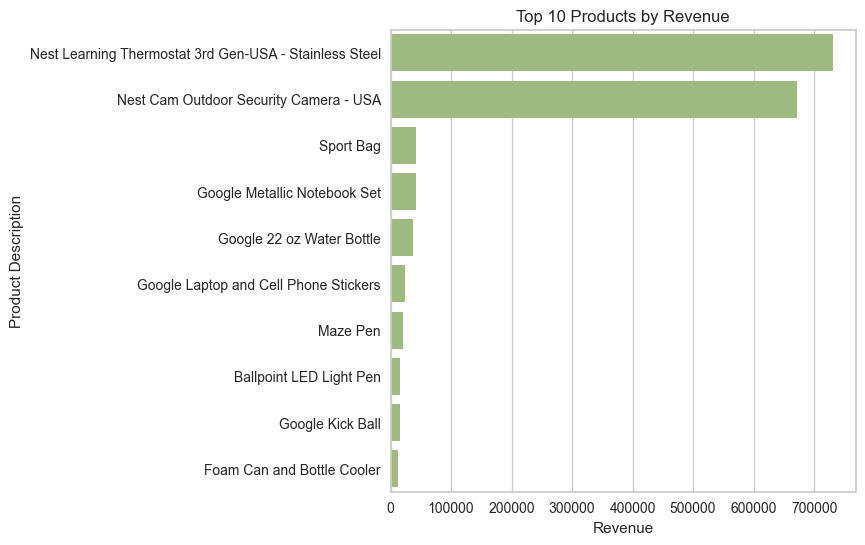

In [29]:
# Sort the DataFrame by 'Revenue' column in descending order
top10_df_sorted = top10_df.sort_values(by='Revenue', ascending=False)

# Create a horizontal bar plot with sorted data
plt.figure(figsize=(6, 6))  # Set the figure size
sns.barplot(data=top10_df_sorted, y='Product Description', x='Revenue', orient='h', color='g')  # Create the horizontal bar plot

# Set plot labels and title
plt.xlabel('Revenue')
plt.ylabel('Product Description')
plt.title('Top 10 Products by Revenue')

# Show the plot
plt.show()


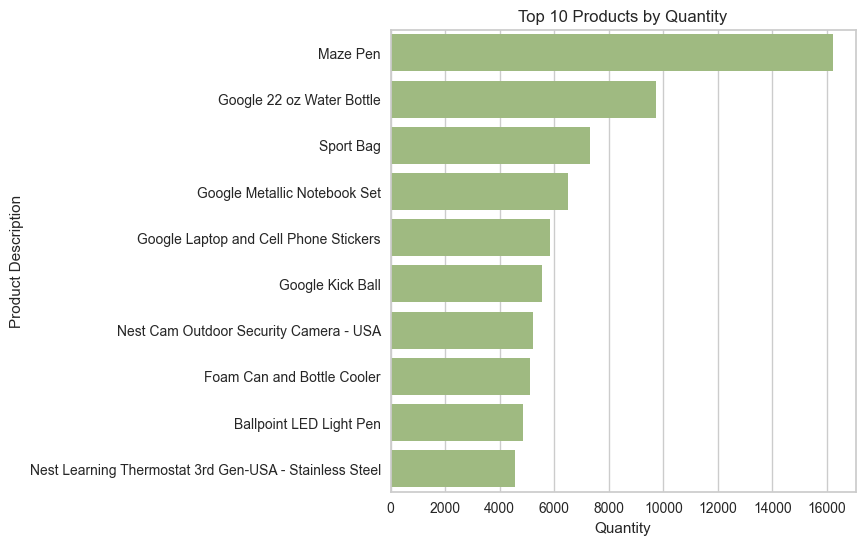

In [30]:
# Sort the DataFrame by 'Quantity' column in descending order
top10_df_sorted = top10_df.sort_values(by='Quantity', ascending=False)

# Create a horizontal bar plot with sorted data
plt.figure(figsize=(6, 6))  # Set the figure size
sns.barplot(data=top10_df_sorted, y='Product Description', x='Quantity', orient='h', color='g')  # Create the horizontal bar plot

# Set plot labels and title
plt.xlabel('Quantity')
plt.ylabel('Product Description')
plt.title('Top 10 Products by Quantity')

# Show the plot
plt.show()


#### Product Groups by Revenue and Quantity

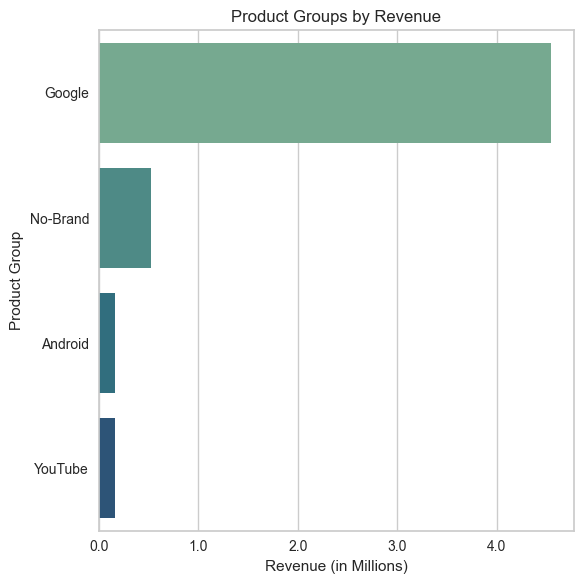

In [31]:
# Sorting the DataFrame by 'Revenue' column in descending order
product_group = sku.groupby('Product Group')['Revenue'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(6, 6))  # Set the figure size

# Create the horizontal bar plot with sorted data
plot = sns.barplot(data=product_group, y='Product Group', x='Revenue', orient='h', palette='crest', ci=None)

# Set x-axis label format (assuming revenue is in millions for example)
plot.set_xlabel('Revenue (in Millions)')

# Set plot labels and title
plt.ylabel('Product Group')
plt.title('Product Groups by Revenue')

# Formatting x-axis labels to display in millions
from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}'

formatter = FuncFormatter(millions_formatter)
plot.xaxis.set_major_formatter(formatter)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent cutoff of labels
plt.show()

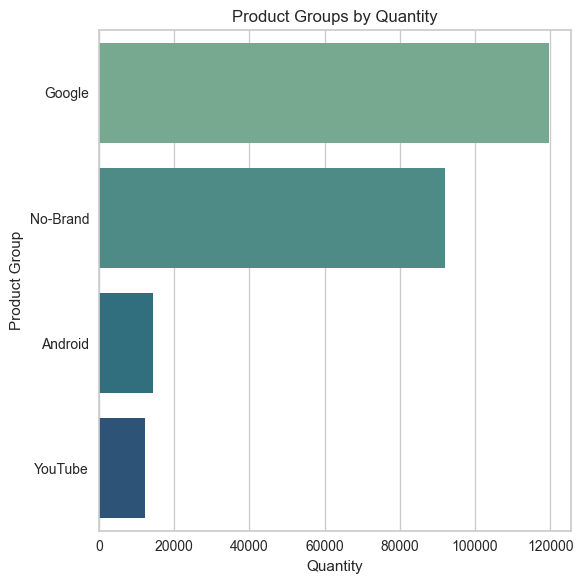

In [32]:
# Sorting the DataFrame by 'Revenue' column in descending order
product_group = sku.groupby('Product Group')['Quantity'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(6, 6))  # Set the figure size

# Create the horizontal bar plot with sorted data
plot = sns.barplot(data=product_group, y='Product Group', x='Quantity', orient='h', palette='crest', ci=None)

# Set x-axis label format (assuming revenue is in millions for example)
plot.set_xlabel('Quantity')

# Set plot labels and title
plt.ylabel('Product Group')
plt.title('Product Groups by Quantity')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent cutoff of labels
plt.show()

#### Product Categories by Revenue and Quantity

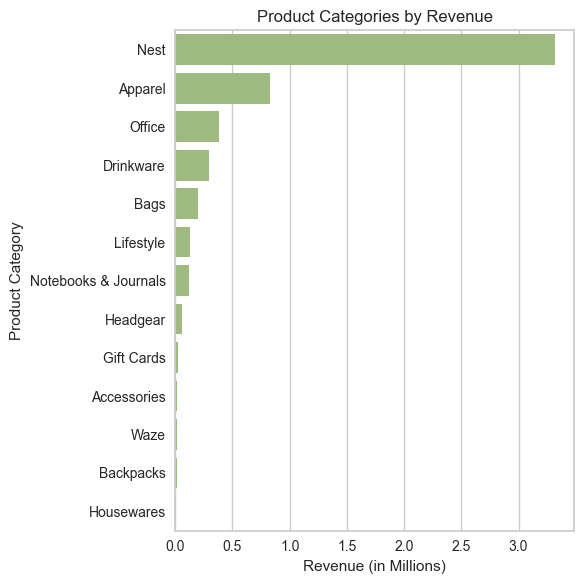

In [33]:
# Sorting the DataFrame by 'Revenue' column in descending order
product_group = sku.groupby('Product Category')['Revenue'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(6, 6))  # Set the figure size

# Create the horizontal bar plot with sorted data
plot = sns.barplot(data=product_group, y='Product Category', x='Revenue', orient='h', color='g', ci=None)

# Set x-axis label format (assuming revenue is in millions for example)
plot.set_xlabel('Revenue (in Millions)')

# Set plot labels and title
plt.ylabel('Product Category')
plt.title('Product Categories by Revenue')

# Formatting x-axis labels to display in millions
from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}'

formatter = FuncFormatter(millions_formatter)
plot.xaxis.set_major_formatter(formatter)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent cutoff of labels
plt.show()

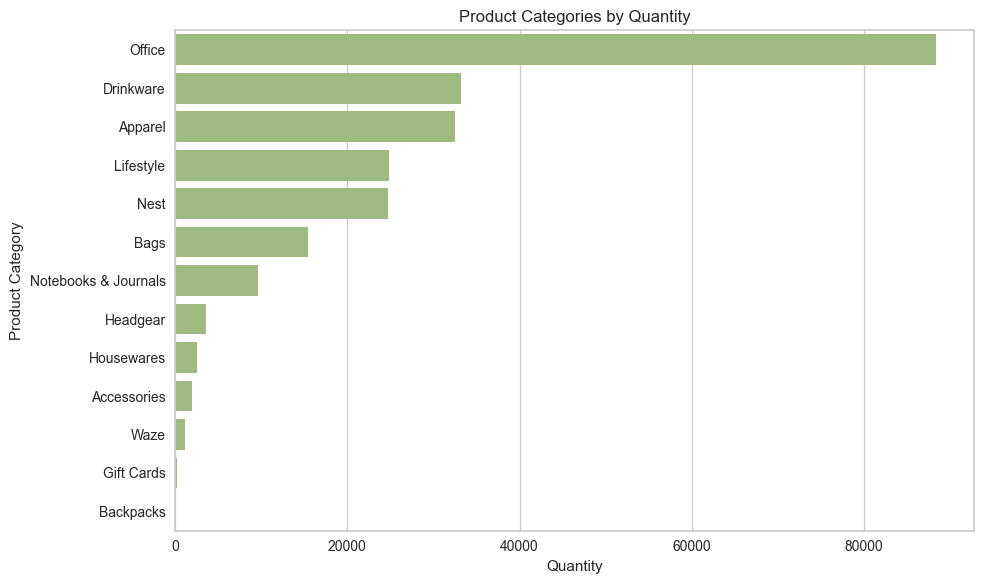

In [34]:
# Sorting the DataFrame by 'Revenue' column in descending order
product_group = sku.groupby('Product Category')['Quantity'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 6))  # Set the figure size

# Create the horizontal bar plot with sorted data
plot = sns.barplot(data=product_group, y='Product Category', x='Quantity', orient='h', color='g', ci=None)

# Set x-axis label format (assuming revenue is in millions for example)
plot.set_xlabel('Quantity')

# Set plot labels and title
plt.ylabel('Product Category')
plt.title('Product Categories by Quantity')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent cutoff of labels
plt.show()

In [35]:
sales.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status', 'Gender', 'Location',
       'Tenure_Months', 'Month', 'InvoiceMonthly', 'InvoiceDaily',
       'Coupon_Code', 'Discount_pct', 'GST', 'Revenue', 'Product_Group'],
      dtype='object')

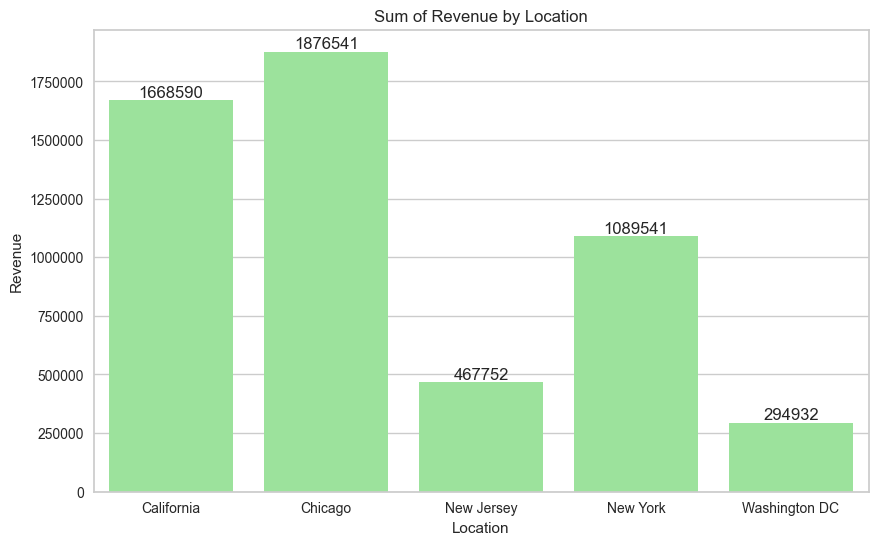

In [36]:
# Group coupon status by revenue
location = sales.groupby('Location')['Revenue'].sum()

# Set figure size
plt.figure(figsize=(10, 6))

# Create a bar chart with x axis of coupon status and y axis as revenue, setting color to green
sns.barplot(x=location.index, y=location, color='lightgreen')

# Annotate each bar with its value (formatted as integers)
for index, value in enumerate(location):
    plt.text(index, value, f'{int(value)}', ha='center', va='bottom')

# Set title
plt.title('Sum of Revenue by Location')

# Format y-axis tick labels as plain numbers
plt.ticklabel_format(style='plain', axis='y')

plt.show()

In [37]:
customer_analysis.head()

,CustomerID,Total_Spending,Delivery_Charges,Num_Transactions,Total_Quantity,Location,Gender,Tenure_Months,Used_Coupon_Count,Not_Use_Coupon_Count,Clicked_Coupon_Count,Revenue
0,12346,25.49,150.00,2,3,New York,F,31,2.0,0.0,0.0,174.98174
1,12347,3746.16,665.14,60,342,New York,M,20,20.0,14.0,26.0,15686.84396
2,12348,336.52,197.15,23,209,California,M,39,11.0,1.0,11.0,1689.55594
3,12350,1312.40,127.88,17,21,California,M,25,6.0,3.0,8.0,1467.43528
4,12356,1244.83,637.49,36,56,Chicago,F,31,11.0,8.0,17.0,2007.42900


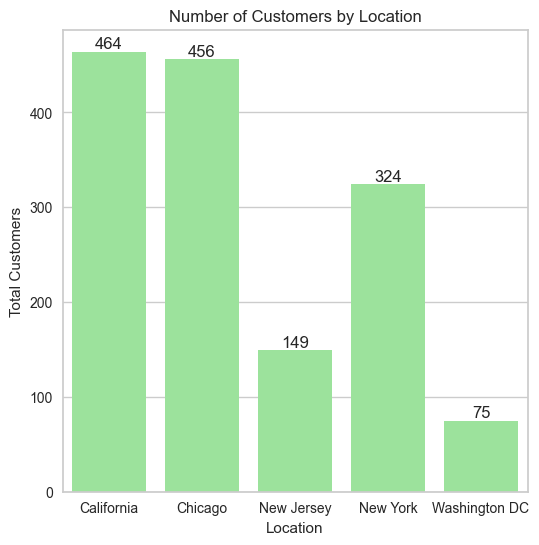

In [38]:
# Group customer count by location
customer_count = customer_analysis.groupby('Location')['CustomerID'].nunique()

# Set figure size
plt.figure(figsize=(6, 6))

# Create a bar chart with x axis of location and y axis as customer count, setting color to green
sns.barplot(x=customer_count.index, y=customer_count, color='lightgreen')

# Annotate each bar with its value (formatted as integers)
for index, value in enumerate(customer_count):
    plt.text(index, value, f'{int(value)}', ha='center', va='bottom')

# Set title
plt.title('Number of Customers by Location')

# Set y-label
plt.ylabel('Total Customers')

# Format y-axis tick labels as plain numbers
plt.ticklabel_format(style='plain', axis='y')

plt.show()

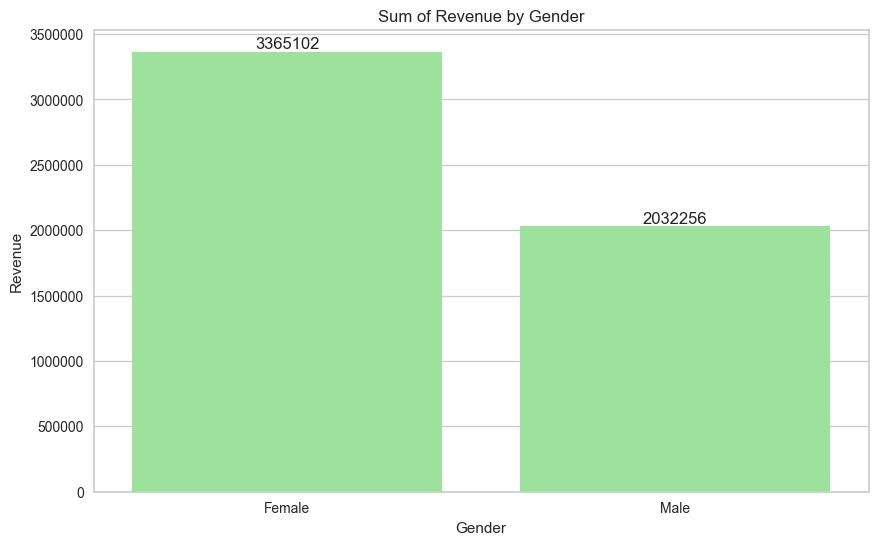

In [39]:

# Group coupon status by revenue
location = sales.groupby('Gender')['Revenue'].sum()

# Set figure size
plt.figure(figsize=(10, 6))

# Create a bar chart with x axis of coupon status and y axis as revenue, setting color to green
sns.barplot(x=location.index, y=location, color='lightgreen')

# Annotate each bar with its value (formatted as integers)
for index, value in enumerate(location):
    plt.text(index, value, f'{int(value)}', ha='center', va='bottom')

# Set title
plt.title('Sum of Revenue by Gender')

# Format y-axis tick labels as plain numbers
plt.ticklabel_format(style='plain', axis='y')

# Set x-axis labels to 'Female' and 'Male'
plt.xticks(range(len(location.index)), ['Female', 'Male'])

plt.show()

#### Marketing Spending vs. Revenue Analysis by Month

In [40]:
# Grouping the 'marketing' DataFrame by 'Month' and calculating the total spend for each month
total_spend = marketing.groupby('Month')['total_spend'].sum().reset_index()

# Grouping the 'sales' DataFrame by 'Month' and summing up the 'Revenue' for each month
invoice = sales.groupby('Month')['Revenue'].sum().reset_index()

# Grouping the 'offline_spend' DataFrame by 'Month' and calculating the total spend for each month
offline_spend = marketing.groupby('Month')['Offline_Spend'].sum().reset_index()

# Grouping the 'online_spend' DataFrame by 'Month' and calculating the total spend for each month
online_spend = marketing.groupby('Month')['Online_Spend'].sum().reset_index()


# Merging the 'total_spend' and 'invoice' DataFrames on the 'Month' column using an inner join
result = total_spend.merge(invoice, on='Month', how='inner')
result = offline_spend.merge(result, on='Month', how='inner')
result = online_spend.merge(result, on='Month', how='inner')
result

,Month,Online_Spend,Offline_Spend,total_spend,Revenue
0,Apr,61026.83,96000,157026.83,477498.59102
1,Aug,57404.15,85500,142904.15,475796.87554
2,Dec,76648.75,122000,198648.75,556112.29179
3,Feb,55807.92,81300,137107.92,375162.04730
4,Jan,58328.95,96600,154928.95,494090.54875
5,Jul,52717.85,67500,120217.85,451878.40904
6,Jun,53818.14,80500,134318.14,361000.17429
7,Mar,48750.09,73500,122250.09,415157.79044
8,May,52759.64,65500,118259.64,365596.02956
9,Nov,68144.96,93000,161144.96,547788.12626


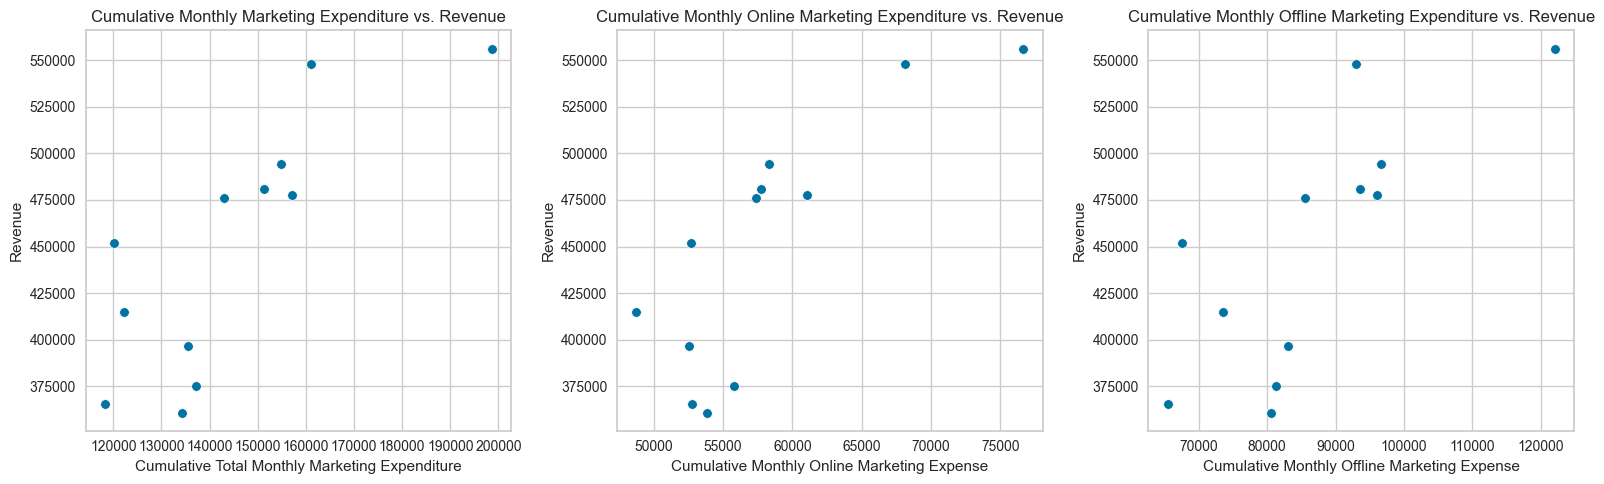

In [41]:
# Create a figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(16, 5))  

# Scatter plot for 'total_spend' vs. 'Revenue'
sns.scatterplot(data=result, x='total_spend', y='Revenue', ax=axs[0])
axs[0].set_title('Cumulative Monthly Marketing Expenditure vs. Revenue')
axs[0].set_xlabel('Cumulative Total Monthly Marketing Expenditure')

# Scatter plot for 'Online_Spend' vs. 'Revenue'
sns.scatterplot(data=result, x='Online_Spend', y='Revenue', ax=axs[1])
axs[1].set_title('Cumulative Monthly Online Marketing Expenditure vs. Revenue')
axs[1].set_xlabel('Cumulative Monthly Online Marketing Expense')

# Scatter plot for 'Offline_Spend' vs. 'Revenue'
sns.scatterplot(data=result, x='Offline_Spend', y='Revenue', ax=axs[2])
axs[2].set_title('Cumulative Monthly Offline Marketing Expenditure vs. Revenue')
axs[2].set_xlabel('Cumulative Monthly Offline Marketing Expense')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

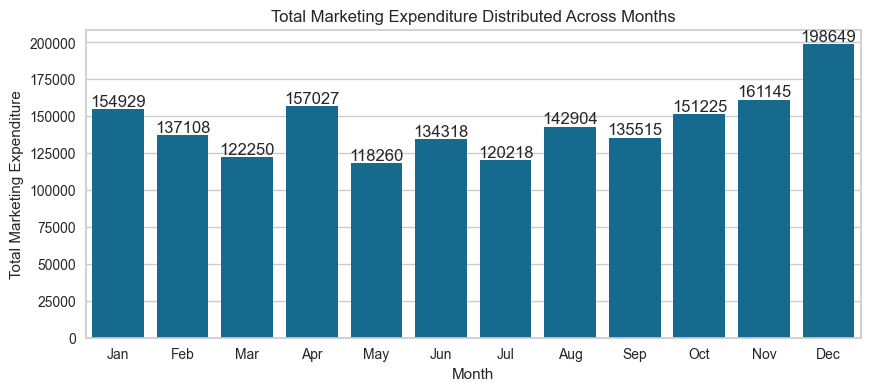

In [43]:
# Labels of months
xticks=['Jan','Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10, 4))
# Create the bar plot for 'total_spend' vs. 'Month'
ax = sns.barplot(data=result, x='Month', y='total_spend', order=xticks)
plt.title('Total Marketing Expenditure Distributed Across Months')  # Set title
plt.ylabel('Total Marketing Expenditure')  # Set y-axis label
ax.bar_label(ax.containers[0]);

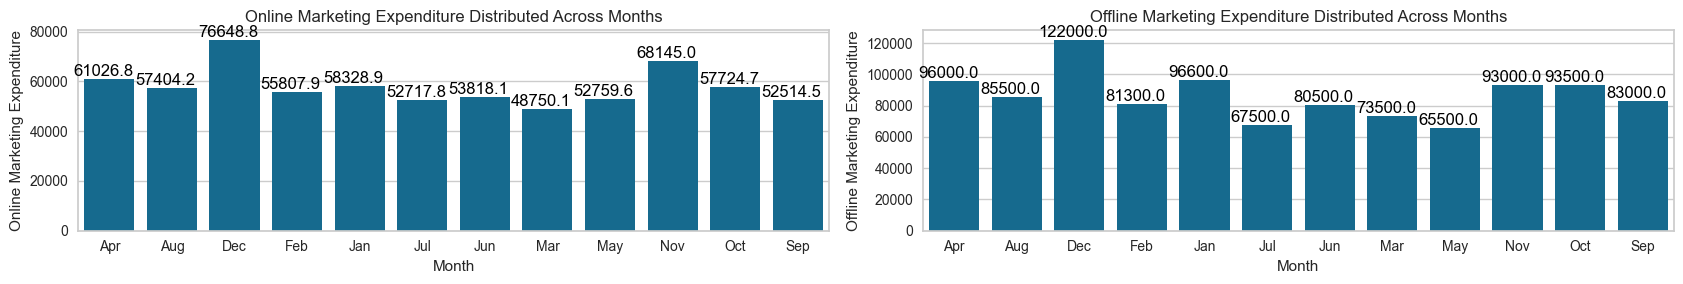

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(17, 3))

# Scatter plot for 'online_spend' vs. 'Revenue'
sns.barplot(data=result, x='Month', y='Online_Spend', ax=axs[0])
axs[0].set_title('Online Marketing Expenditure Distributed Across Months')
axs[0].set_ylabel('Online Marketing Expenditure')

# Annotate each bar with its value for the 'Online_Spend' column
for bar, value in zip(axs[0].patches, result['Online_Spend']):
    axs[0].text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{value:.1f}', ha='center', va='bottom', color='black')

# Scatter plot for 'offline_spend' vs. 'Revenue'
sns.barplot(data=result, x='Month', y='Offline_Spend', ax=axs[1])
axs[1].set_title('Offline Marketing Expenditure Distributed Across Months')
axs[1].set_ylabel('Offline Marketing Expenditure')

# Annotate each bar with its value for the 'Offline_Spend' column
for bar, value in zip(axs[1].patches, result['Offline_Spend']):
    axs[1].text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, f'{value:.1f}', ha='center', va='bottom', color='black')

plt.tight_layout()  # Adjust layout to prevent overlapping annotations
plt.show()

In [45]:
# Correlation of total spend and Revenue
corr = result['total_spend'].corr(result['Revenue'])
corr

0.79628352475623

In [46]:
# Correlation of total spend and Revenue
corr = result['Online_Spend'].corr(result['Revenue'])
corr

0.8108425833524816

In [47]:
# Correlation of total spend and Revenue
corr = result['Offline_Spend'].corr(result['Revenue'])
corr

0.7565406262584905

#### Coupon Usage vs. Revenue Analysis

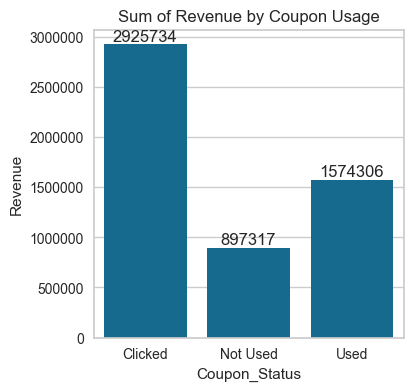

In [48]:
# Group coupon status by revenue
coupon = sales.groupby('Coupon_Status')['Revenue'].sum()

# Set figure size
plt.figure(figsize=(4, 4))

# Create a bar chart with x axis of coupon status and y axis as revenue
sns.barplot(x=coupon.index, y=coupon)

# Annotate each bar with its value (formatted as integers)
for index, value in enumerate(coupon):
    plt.text(index, value, f'{int(value)}', ha='center', va='bottom')

# Set title
plt.title('Sum of Revenue by Coupon Usage')

# Format y-axis tick labels as plain numbers
plt.ticklabel_format(style='plain', axis='y')

plt.show()


In [49]:
# Filtering sales DataFrame for 'Used', 'Not Used', and 'Clicked' coupons
used_coupon = sales[sales['Coupon_Status'] == 'Used'].groupby('Month').size().reset_index(name='Used_Count')
unused_coupon = sales[sales['Coupon_Status'] == 'Not Used'].groupby('Month').size().reset_index(name='Not_Used_Count')
clicked_coupon = sales[sales['Coupon_Status'] == 'Clicked'].groupby('Month').size().reset_index(name='Clicked_Count')

# Grouping the customer_analysis DataFrame by 'CustomerID' and summing up the 'Revenue' for each customer
invoice = sales.groupby('Month')['Revenue'].sum().reset_index()

# Merging the coupon DataFrames with the invoice DataFrame on 'CustomerID'
coupon = used_coupon.merge(invoice, on='Month', how='inner')
coupon = unused_coupon.merge(coupon, on='Month', how='inner')
coupon = clicked_coupon.merge(coupon, on='Month', how='inner')


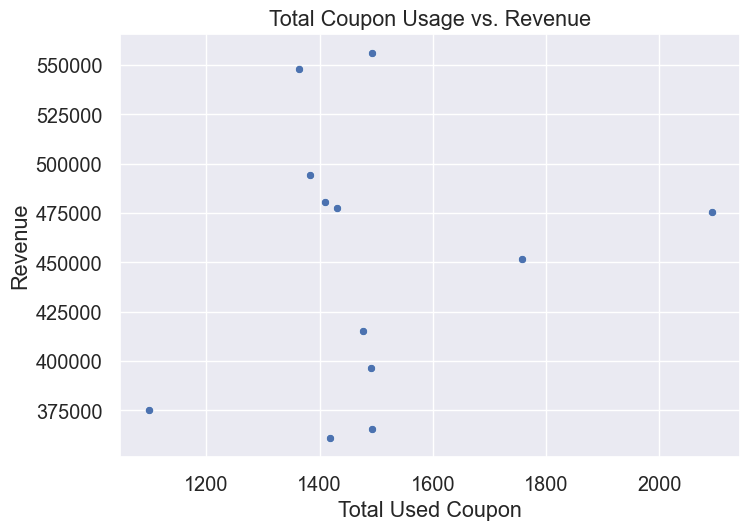

In [137]:
# Create a scatter plot using Seaborn's scatterplot function to show the relationship between 'Used_Coupon_Count' and 'Revenue'
sns.scatterplot(data=coupon, x='Used_Count', y='Revenue')

# Set the title of the plot
plt.title('Total Coupon Usage vs. Revenue')
plt.xlabel('Total Used Coupon');

In [51]:
# Correlation of Used Coupon and Revenue
corr = coupon['Used_Count'].corr(coupon['Revenue'])
corr

0.17531930666975015

In [52]:
# Correlation of Not Used Coupon and Revenue
corr = coupon['Not_Used_Count'].corr(coupon['Revenue'])
corr

0.07417376360418083

In [53]:
# Correlation of Clicked Coupon and Revenue
corr = coupon['Clicked_Count'].corr(coupon['Revenue'])
corr

0.16256478977881422

#### Customer's Location Distribution

In [54]:
# Count of each customer's location
customer_analysis['Location'].value_counts()

Location
California       464
Chicago          456
New York         324
New Jersey       149
Washington DC     75
Name: count, dtype: int64

### Data Encoding

In [55]:
# Encode subdistrict rank based on price into subdistrict column

# Group subdistrict by price mean, sort ascending
location_order = customer_analysis.groupby('Location')['Revenue'].mean().sort_values(ascending=True).index

# Create dictionary of subdistrict and rank
location_encode_dict = {sub:i for i, sub in enumerate(location_order)}

# Encode subdistrict column with the encode dictionary
customer_analysis['Location'] = customer_analysis['Location'].map(location_encode_dict)

In [56]:
# Encode subdistrict rank based on price into subdistrict column

# Group subdistrict by price mean, sort ascending
gender_order = customer_analysis.groupby('Gender')['Revenue'].mean().sort_values(ascending=True).index

# Create dictionary of subdistrict and rank
gender_encode_dict = {sub:i for i, sub in enumerate(gender_order)}

# Encode subdistrict column with the encode dictionary
customer_analysis['Gender'] = customer_analysis['Gender'].map(gender_encode_dict)

### Correlation Heatmap: Customer Analysis

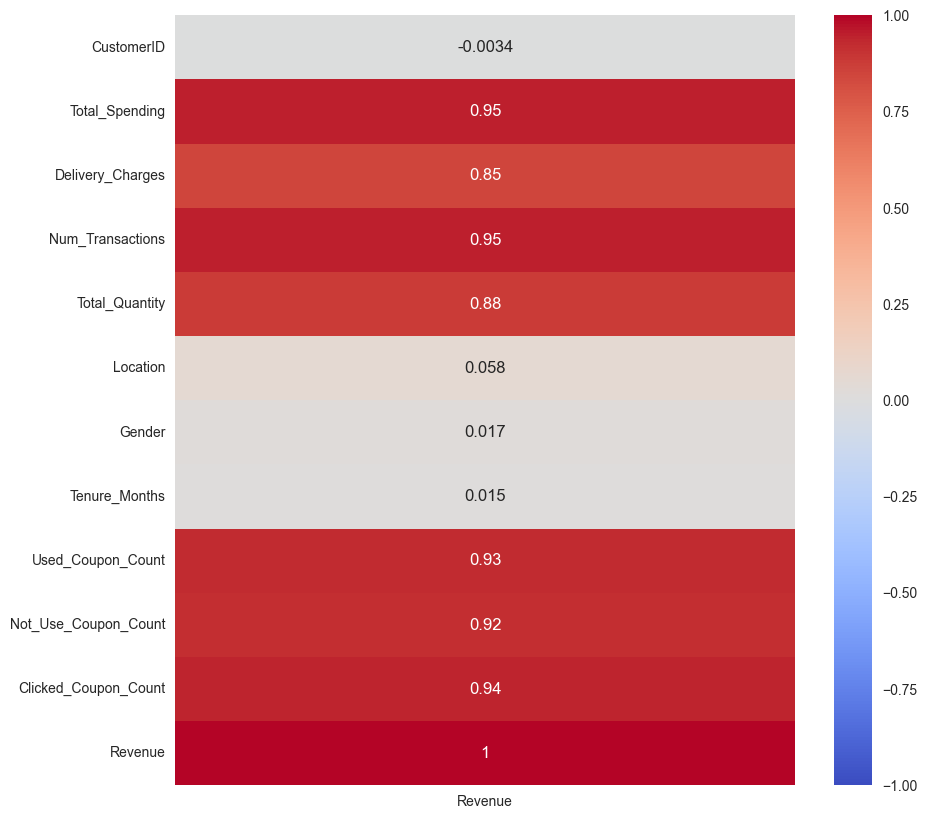

In [57]:
# Create a heatmap using Seaborn to visualize correlations between 'WnvPresent' and 'NumMosquitos' columns in the 'train_df' DataFrame
plt.figure(figsize=(10, 10))  # Set the size of the heatmap figure

# Use train_df.corr() to calculate the correlation matrix for numeric columns only and extract correlations with 'WnvPresent' and 'NumMosquitos'
# Create a heatmap with annotations showing correlation values
sns.heatmap(customer_analysis.corr(numeric_only=True)[['Revenue']], annot=True, vmin=-1, vmax=1, cmap="coolwarm")

sns.set(font_scale=1.3)  # Set the font scale for better readability of annotations

### RFM Analysis

**Definitions**
- Recency: The duration between now and last purchase. How long since customer last purchase
- Frequency: How often does a customer buy
- Monetary Value: Total revenue gained from the customer during their tenure

#### RFM Summary 

In [59]:
# Get the maximum transaction date to set it as the end of the observation period
endDate = sales['Transaction_Date'].max()

# Generate an RFM DataFrame using the 'summary_data_from_transaction_data' function from the 'lifetimes' library
rfm = summary_data_from_transaction_data(
    sales,  # DataFrame containing transaction data
    customer_id_col='CustomerID',  # Column name representing the customer ID
    datetime_col='Transaction_Date',  # Column name representing the transaction date
    monetary_value_col='Revenue',  # Column name representing the revenue/monetary value
    observation_period_end=endDate,  # End date of the observation period (in this case, the maximum transaction date)
    freq='D',  # Frequency of time units for analysis (in this case, 'D' for days)
    include_first_transaction=True  # Flag to include the first transaction for each customer
)

rfm = rfm.rename(columns={'recency': 'Days_Since_Last_Purchase'})

rfm.head(5)

,frequency,Days_Since_Last_Purchase,T,monetary_value
CustomerID,,,,
12346,1.0,0.0,107.0,174.981740
12347,3.0,223.0,282.0,5228.947987
12348,2.0,119.0,192.0,844.777970
12350,1.0,0.0,17.0,1467.435280
12356,1.0,0.0,107.0,2007.429000


In [77]:
rfm.head()

,frequency,Days_Since_Last_Purchase,Tenure_Days,Monetary_Value,Predicted_Purchases,Predicted_Revenue,CLV
CustomerID,,,,,,,
12346,1.0,0.0,107.0,174.981740,0.175161,1488.523498,251.968402
12347,3.0,223.0,282.0,5228.947987,1.796198,2798.601724,4856.521721
12348,2.0,119.0,192.0,844.777970,1.607770,1491.563966,2317.038963
12350,1.0,0.0,17.0,1467.435280,2.259136,1659.302471,3623.714932
12356,1.0,0.0,107.0,2007.429000,0.175161,1730.654802,292.954948


In [63]:
# Calculate the difference in time between the maximum and minimum transaction dates
diff_time = sales['Transaction_Date'].max() - sales['Transaction_Date'].min() 

# Get data time period
diff_time

Timedelta('364 days 00:00:00')

In [64]:
print('max_date:', sales['Transaction_Date'].max())
print('min_date:', sales['Transaction_Date'].min())

max_date: 2019-12-31 00:00:00
min_date: 2019-01-01 00:00:00


In [65]:
# Calculate the ending date of the calibration period by adding 200 days to the minimum transaction date
end_date_cal = sales['Transaction_Date'].min() + dt.timedelta(days=200)

# Calculate the ending date of the observation period based on the calibration period and the overall duration
end_date_obs = end_date_cal + (diff_time - dt.timedelta(days=164))

#### RFM's Calibration and Holdout Data 

In [66]:
# Generate an RFM DataFrame designed for calibration and holdout periods using the 'calibration_and_holdout_data' function
df_rfmt_cal = calibration_and_holdout_data(
    transactions=sales,  # DataFrame containing transaction data
    customer_id_col="CustomerID",  # Column representing the customer ID
    datetime_col="Transaction_Date",  # Column representing the transaction date
    calibration_period_end=end_date_cal,  # End date of the calibration period
    observation_period_end=end_date_obs  # End date of the observation period
)

df_rfmt_cal = df_rfmt_cal.rename(columns={'recency_cal': 'Days_Since_Last_Purchase_cal'})

df_rfmt_cal.head(5)

,frequency_cal,Days_Since_Last_Purchase_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12347,0.0,0.0,118.0,2.0,200.0
12348,0.0,0.0,28.0,1.0,200.0
12370,1.0,30.0,55.0,0.0,200.0
12377,0.0,0.0,15.0,1.0,200.0
12383,1.0,1.0,7.0,2.0,200.0


#### L2 Coefficients Evaluation

In [67]:
# List of L2 penalty coefficients
l2_coefs = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Empty lists to store coefficients and corresponding RMSE scores
l2_list = []
rmse_list = []

# Iterate through each L2 penalty coefficient
for coef in l2_coefs:
    # Fitting the BetaGeoFitter model using the calibration dataset
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(df_rfmt_cal['frequency_cal'], 
              df_rfmt_cal['Days_Since_Last_Purchase_cal'], 
              df_rfmt_cal['T_cal'])
    
    # Predicting the frequency for the holdout period for all customers
    pred_freq = pd.DataFrame(model.predict(df_rfmt_cal['duration_holdout'], 
                                           df_rfmt_cal['frequency_cal'], 
                                           df_rfmt_cal['Days_Since_Last_Purchase_cal'], 
                                           df_rfmt_cal['T_cal']),
                             columns=['pred_frequency']).reset_index()
    
    # Merging the two dataframes and dropping NaN values
    new_df = df_rfmt_cal.reset_index().merge(pred_freq, on='CustomerID').dropna()

    # Computing the RMSE score 
    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'], new_df['pred_frequency']))
    
    # Appending the current coefficient and its RMSE score to respective lists
    l2_list.append(coef)
    rmse_list.append(rmse_score)

# Creating a DataFrame to store and display the results
resl = pd.DataFrame(np.array(rmse_list), columns=['rmse_score']).merge(
    pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)

# Displaying the RMSE scores and corresponding L2 coefficients
resl


,rmse_score,L2 coefs
0,1.828853,0.3
1,1.863270,0.4
2,1.893750,0.5
3,1.919949,0.6
4,1.943813,0.7
5,1.964510,0.8
6,1.982715,0.9
7,1.998907,1.0


#### RFM Summary: Adding Predicted_Purchases Column

In [68]:
# Create an instance of the Beta-Geometric (BG) model with a penalizer coefficient of 0.30 (lowest RMSE score)
model = BetaGeoFitter(penalizer_coef=0.30)

# Fit the BG model using the 'frequency_cal', 'recency_cal', and 'T_cal' columns from the 'df_rfmt_cal' DataFrame
model.fit(df_rfmt_cal['frequency_cal'], 
          df_rfmt_cal['Days_Since_Last_Purchase_cal'], 
          df_rfmt_cal['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 966 subjects, a: 0.07, alpha: 15.85, b: 0.11, r: 0.26>

In [69]:
# Predicting the number of purchases in the next 180 days for all customers.
rfm['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(180, 
                                                                                      rfm['frequency'], 
                                                                                      rfm['Days_Since_Last_Purchase'],                                                                                       rfm['T'])
rfm.dropna(inplace=True)
# Getting rid of negative values.
rfm = rfm[rfm['monetary_value']>0]
rfm

,frequency,Days_Since_Last_Purchase,T,monetary_value,predicted_purchases
CustomerID,,,,,
12346,1.0,0.0,107.0,174.981740,0.175161
12347,3.0,223.0,282.0,5228.947987,1.796198
12348,2.0,119.0,192.0,844.777970,1.607770
12350,1.0,0.0,17.0,1467.435280,2.259136
12356,1.0,0.0,107.0,2007.429000,0.175161
...,...,...,...,...,...
18259,1.0,0.0,270.0,860.686000,0.028559
18260,3.0,105.0,192.0,1005.514573,2.271108
18269,2.0,76.0,270.0,83.453750,0.742627


#### RFM Summary: Adding Predicted Revenue and CLV columns

In [70]:
# Initialize an instance of the Gamma-Gamma model
gg_model = GammaGammaFitter()

# Fit the Gamma-Gamma model using the 'frequency' and 'monetary_value' columns from the RFM DataFrame
gg_model.fit(rfm['frequency'], rfm['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 1468 subjects, p: 0.74, q: 5.88, v: 11090.15>

In [71]:
# Predict the conditional expected average transaction value per customer using the fitted Gamma-Gamma model
rfm['pred_monetary'] = gg_model.conditional_expected_average_profit(
    rfm['frequency'],  # Customer purchase frequency data
    rfm['monetary_value']  # Customer average monetary value per transaction data
)

In [72]:
# Predict the Customer Lifetime Value (CLV) using the fitted Gamma-Gamma model
rfm['CLV'] = gg_model.customer_lifetime_value(
    model,  # Fitted BG model
    rfm['frequency'],  # Customer purchase frequency data
    rfm['Days_Since_Last_Purchase'],  # Customer recency data
    rfm['T'],  # Customer age or duration data
    rfm['monetary_value'],  # Customer average monetary value per transaction data
    time=6,  # Prediction period in months
)

rfm = rfm.rename(columns={'T': 'Tenure_Days', 'monetary_value': 'Monetary_Value', 'predicted_purchases': 'Predicted_Purchases', 'pred_monetary': 'Predicted_Revenue'})

rfm

,frequency,Days_Since_Last_Purchase,Tenure_Days,Monetary_Value,Predicted_Purchases,Predicted_Revenue,CLV
CustomerID,,,,,,,
12346,1.0,0.0,107.0,174.981740,0.175161,1488.523498,251.968402
12347,3.0,223.0,282.0,5228.947987,1.796198,2798.601724,4856.521721
12348,2.0,119.0,192.0,844.777970,1.607770,1491.563966,2317.038963
12350,1.0,0.0,17.0,1467.435280,2.259136,1659.302471,3623.714932
12356,1.0,0.0,107.0,2007.429000,0.175161,1730.654802,292.954948
...,...,...,...,...,...,...,...
18259,1.0,0.0,270.0,860.686000,0.028559,1579.129362,43.573631
18260,3.0,105.0,192.0,1005.514573,2.271108,1474.363260,3235.184653
18269,2.0,76.0,270.0,83.453750,0.742627,1313.850353,942.668120


array([[<Axes: title={'center': 'frequency'}>,
        <Axes: title={'center': 'Days_Since_Last_Purchase'}>,
        <Axes: title={'center': 'Tenure_Days'}>],
       [<Axes: title={'center': 'Monetary_Value'}>,
        <Axes: title={'center': 'Predicted_Purchases'}>,
        <Axes: title={'center': 'Predicted_Revenue'}>],
       [<Axes: title={'center': 'CLV'}>, <Axes: >, <Axes: >]],
      dtype=object)

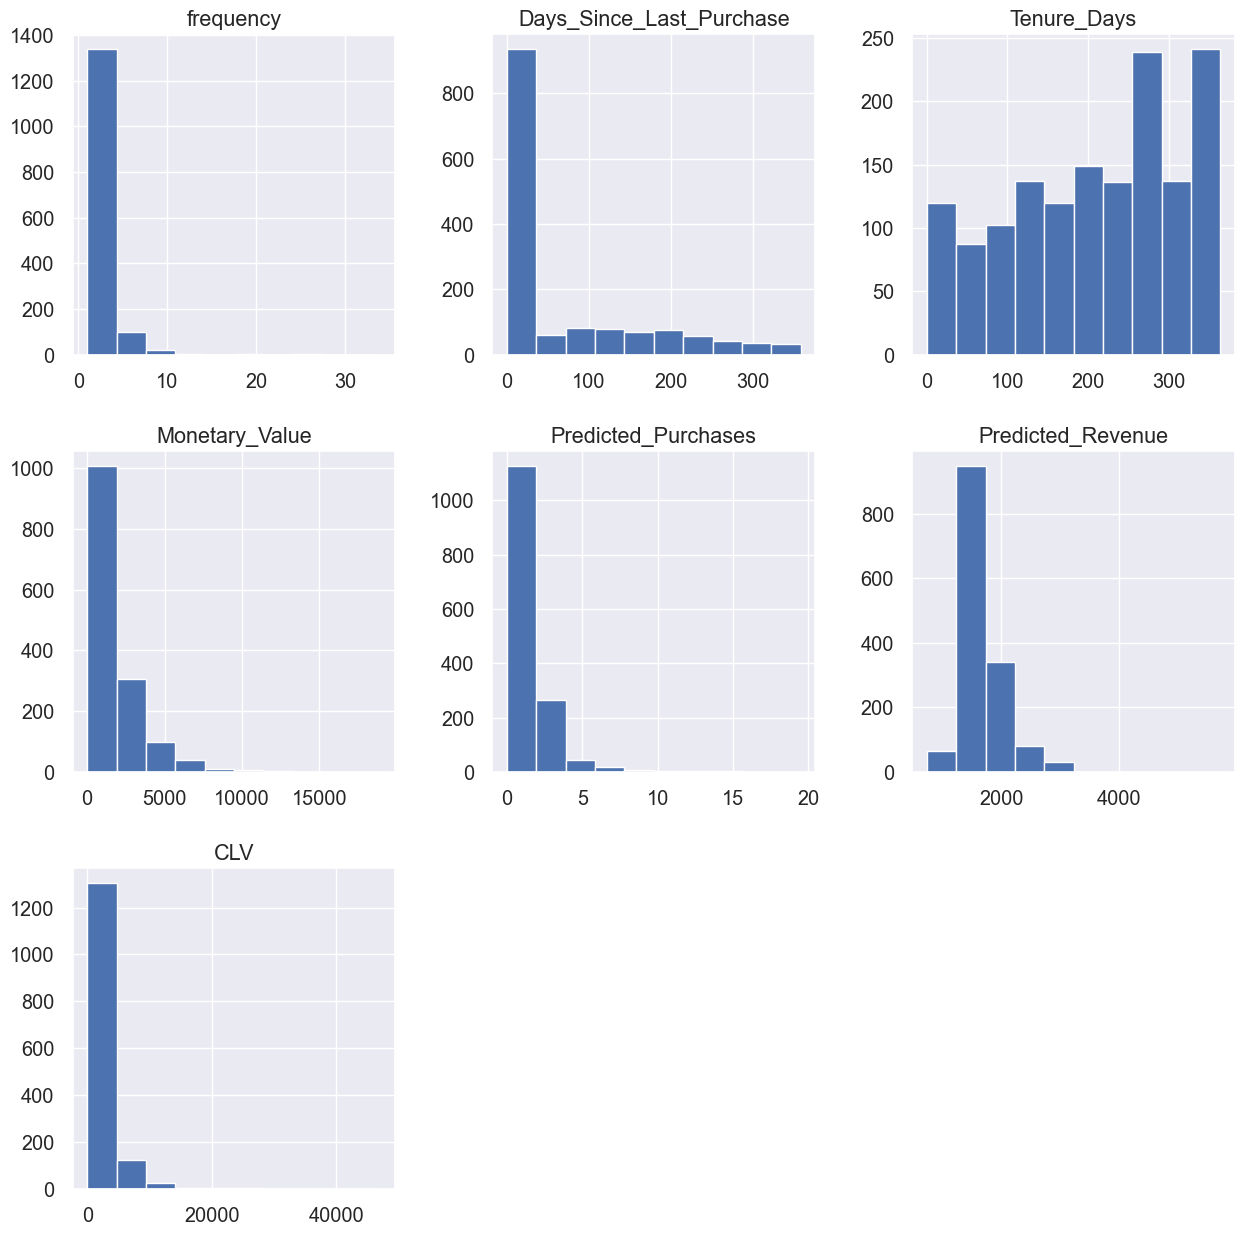

In [75]:
rfm.hist(figsize=(15, 15))

<Axes: >

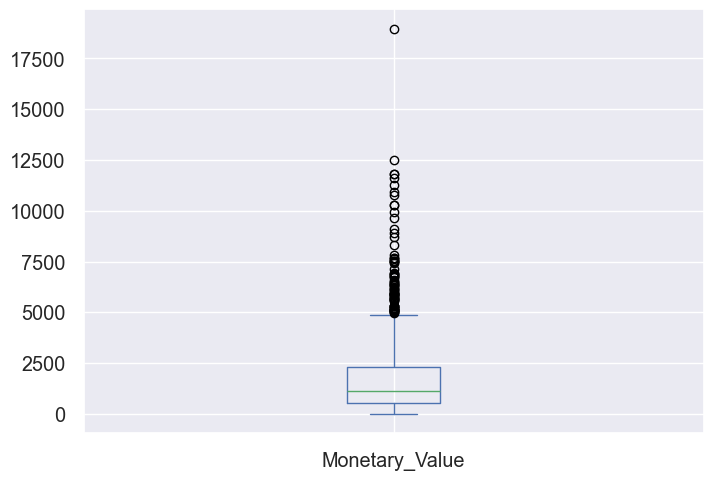

In [103]:
rfm['Monetary_Value'].plot(kind='box')

<Axes: ylabel='Frequency'>

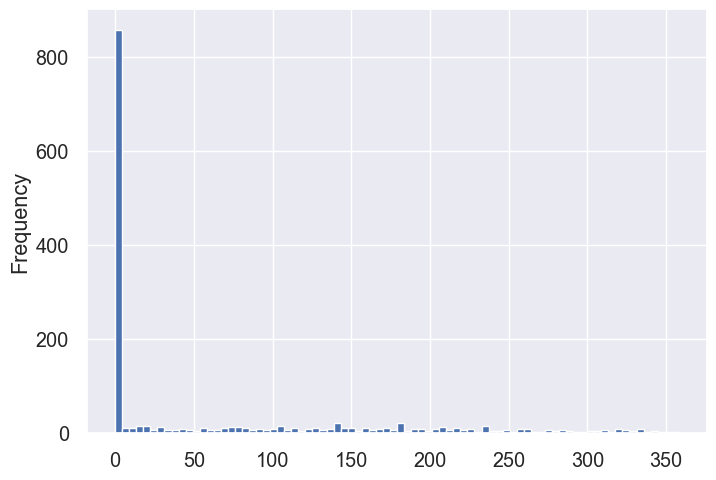

In [136]:
rfm['Days_Since_Last_Purchase'].plot(kind='hist', bins=80)

#### K-Means Clustering 

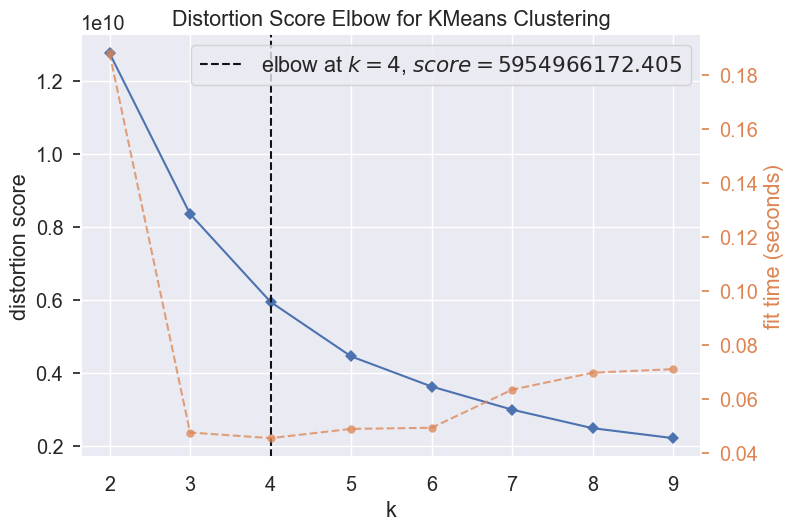

In [67]:
# Instantiate the clustering model and visualizer

# Initialize KMeans clustering model
km_model = KMeans()

# Create an elbow visualizer for k range from 2 to 10
visualizer = KElbowVisualizer(km_model, k=(2,10))

# Fit the data to the visualizer
visualizer.fit(rfm)       
visualizer.show();   

In [68]:
# Instantiate KMeans clustering model with 4 clusters and fit it to the data
km_model = KMeans(n_clusters=4)  # Initialize KMeans clustering model with 4 clusters
km_model.fit(rfm)  # Fit the KMeans model to the 'rfm' data

# Create a new column named 'cluster' containing the cluster labels for each point in the dataset
rfm['cluster'] = km_model.labels_

In [69]:
# Grouping the 'rfm' DataFrame by clusters to compute aggregate statistics related to CLV and customer count
df_clusters = rfm.groupby(['cluster'])['CLV'] \
                 .agg(['mean', 'count']) \
                 .reset_index()

# Renaming the columns for better readability
df_clusters.columns = ["cluster", "avg_CLV", "n_customers"]

# Computing the percentage of customers in each cluster
df_clusters['perct_customers'] = (df_clusters['n_customers'] / df_clusters['n_customers'].sum()) * 100

# Displaying the DataFrame containing aggregate statistics for each cluster
df_clusters


,cluster,avg_CLV,n_customers,perct_customers
0,0,937.349011,167,11.376022
1,1,5298.274655,306,20.844687
2,2,23574.300816,18,1.226158
3,3,771.132564,977,66.553134


In [70]:
rfm.groupby(['cluster']).mean()

,frequency,Days_Since_Last_Purchase,Tenure_Days,Monetary_Value,Predicted_Purchases,Predicted_Revenue,CLV
cluster,,,,,,,
0,1.425150,21.239521,192.652695,5186.549731,0.419298,2262.842475,937.349011
1,3.852941,147.428105,189.575163,1922.572026,3.238363,1743.655599,5298.274655
2,7.944444,95.611111,104.944444,3180.230730,11.991398,2164.184487,23574.300816
3,1.686796,45.136131,219.271238,1017.461273,0.540214,1560.105949,771.132564


In [71]:
# Mapping cluster labels to customer categories and creating a new column 'customer_category'
rfm['customer_category'] = rfm['cluster'].replace({0:"Segment1", 1:"Segment2", 2:"Segment3", 3:"Segment4"})

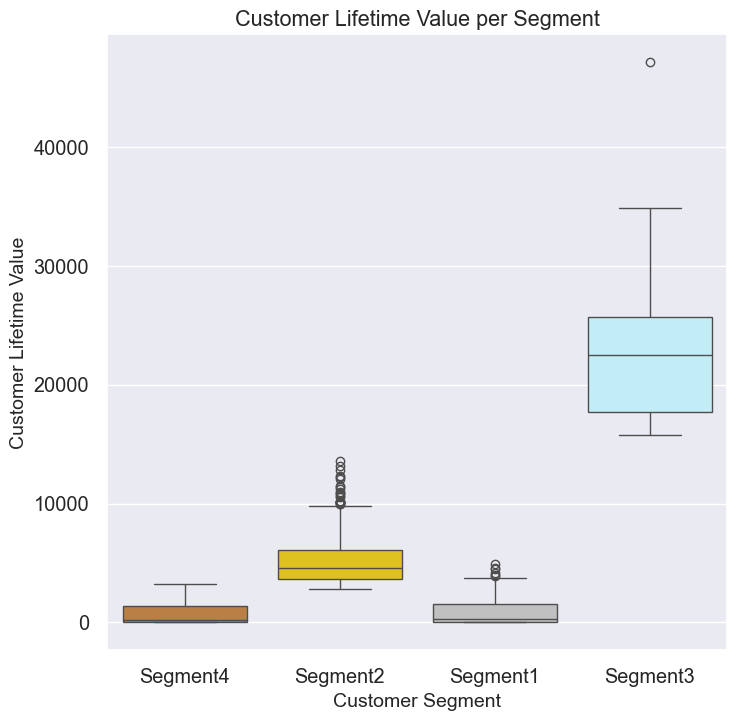

In [72]:
# Defining the plot size
plt.figure(figsize=(8, 8))
# Create boxplot with customer_category as x label and CLV as value
sns.boxplot(x="customer_category", y="CLV", data=rfm, palette=['#CD7F32', '#FFD700', '#C0C0C0', '#B9F2FF'])
# Set x label
plt.xlabel("Customer Segment", size=14)
# Set y label
plt.ylabel("Customer Lifetime Value", size=14)
# Set title
plt.title("Customer Lifetime Value per Segment")
plt.show()

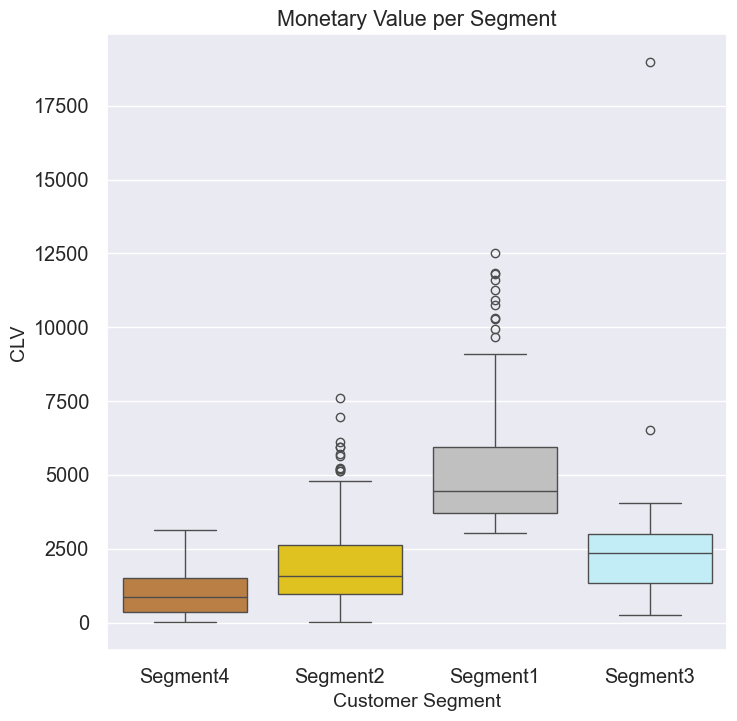

In [73]:
# Defining the plot size
plt.figure(figsize=(8, 8))
# Create boxplot with customer_category as x label and CLV as value
sns.boxplot(x="customer_category", y="Monetary_Value", data=rfm, palette=['#CD7F32', '#FFD700', '#C0C0C0', '#B9F2FF'])
# Set x label
plt.xlabel("Customer Segment", size=14)
# Set y label
plt.ylabel("CLV", size=14)
# Set title
plt.title("Monetary Value per Segment")
plt.show()

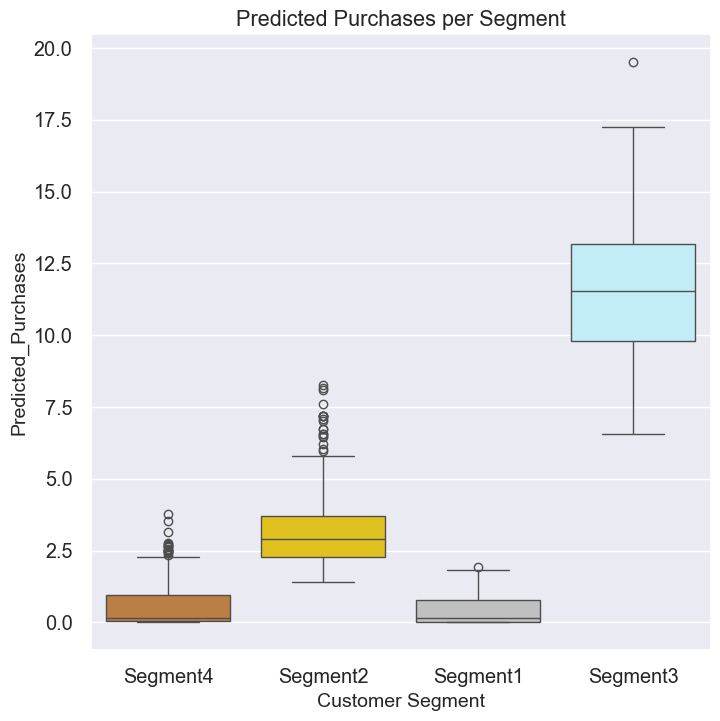

In [74]:
# Defining the plot size
plt.figure(figsize=(8, 8))
# Create boxplot with customer_category as x label and CLV as value
sns.boxplot(x="customer_category", y="Predicted_Purchases", data=rfm, palette=['#CD7F32', '#FFD700', '#C0C0C0', '#B9F2FF'])
# Set x label
plt.xlabel("Customer Segment", size=14)
# Set y label
plt.ylabel("Predicted_Purchases", size=14)
# Set title
plt.title("Predicted Purchases per Segment")
plt.show()

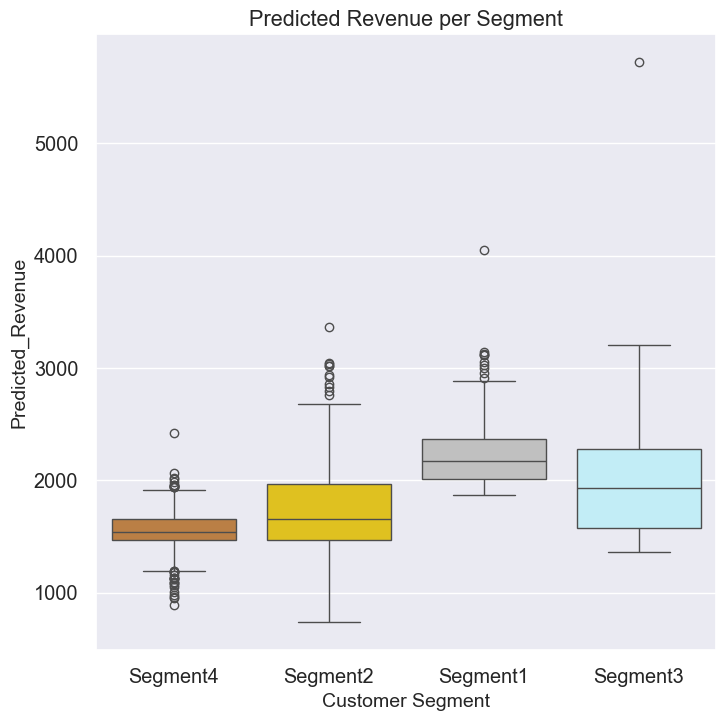

In [75]:
# Defining the plot size
plt.figure(figsize=(8, 8))
# Create boxplot with customer_category as x label and CLV as value
sns.boxplot(x="customer_category", y="Predicted_Revenue", data=rfm, palette=['#CD7F32', '#FFD700', '#C0C0C0', '#B9F2FF'])
# Set x label
plt.xlabel("Customer Segment", size=14)
# Set y label
plt.ylabel("Predicted_Revenue", size=14)
# Set title
plt.title("Predicted Revenue per Segment")
plt.show()

**RFM Analysis Evaluation**
- K-Means Clustering of rfm data yields 4 groups of customers
- Customer category names are classified using CLV: Diamond>Gold>Silver>Bronze

### Customer Analysis + RFM Analysis Correlation 

In [77]:
rfm.reset_index(inplace=True)

In [78]:
customer_analysis = customer_analysis.merge(rfm, how='inner')

customer_analyis = customer_analysis.drop(columns=['cluster'], inplace=True)

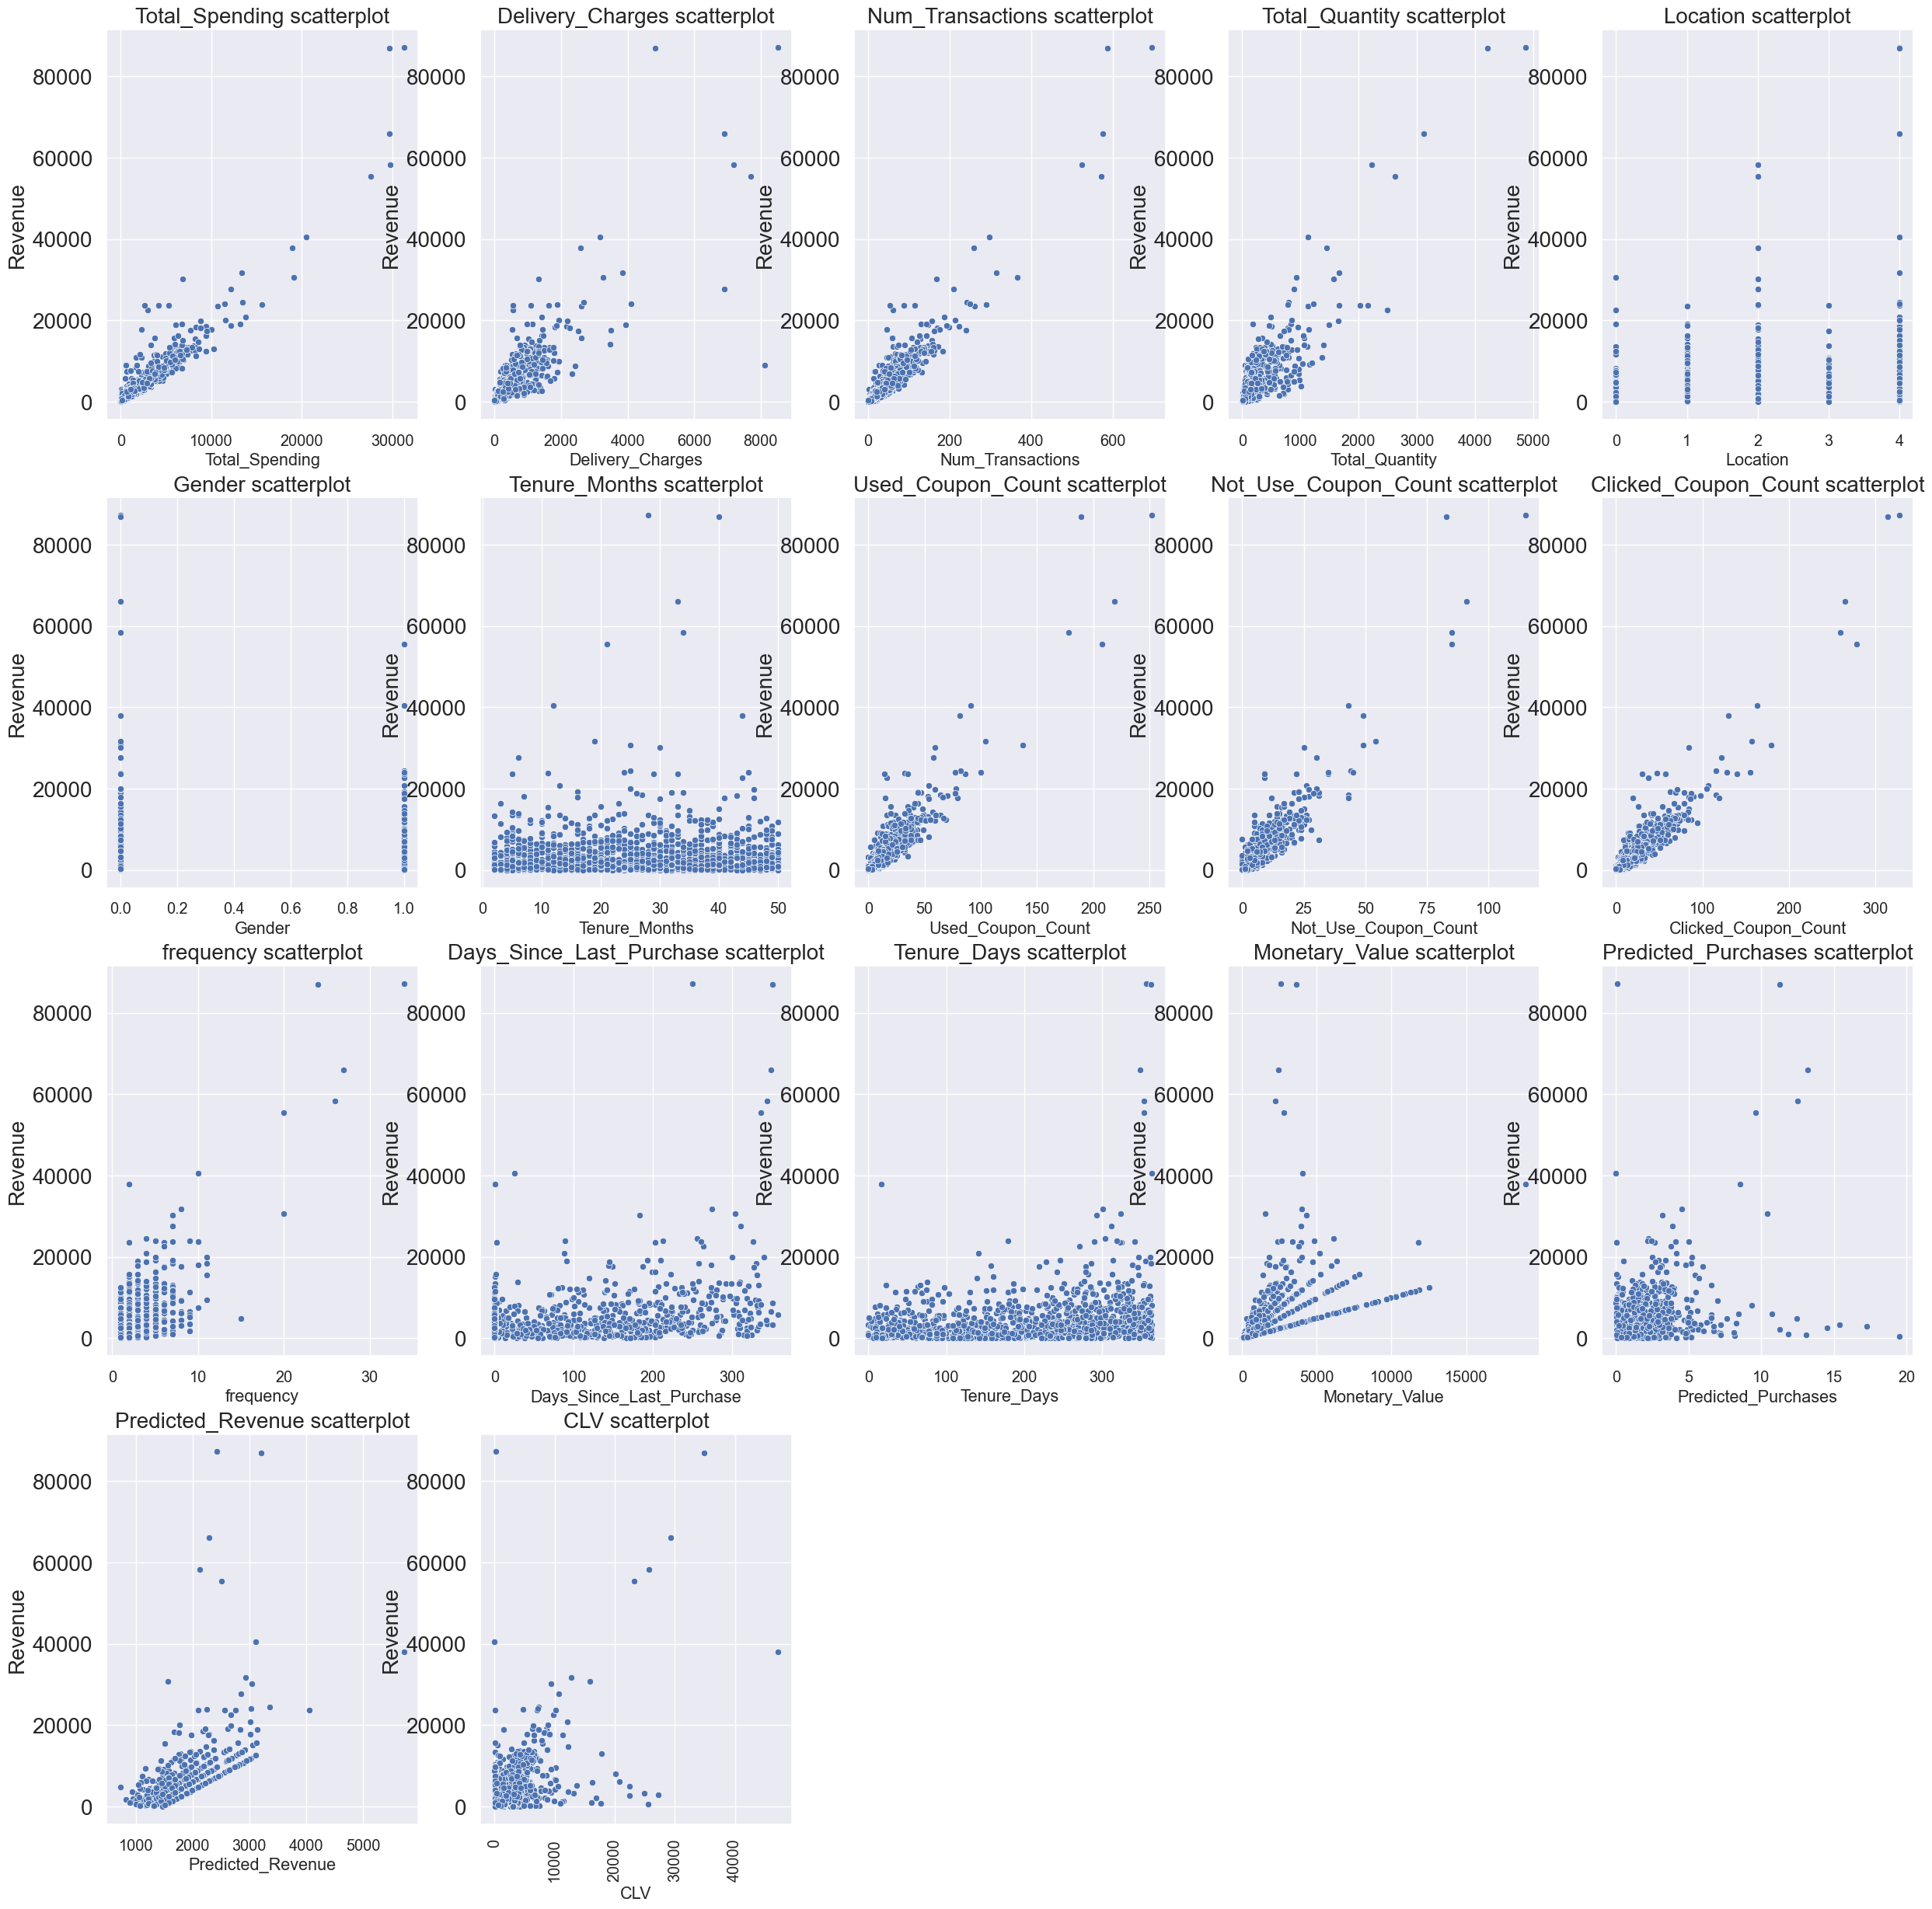

In [79]:
# Regression plots of features with positive correlation with price

# Set figure size
plt.figure(figsize=(30, 30))

# Select columns displayed
columns = ['Total_Spending', 'Delivery_Charges', 'Num_Transactions', 'Total_Quantity',
            'Location', 'Gender', 'Tenure_Months',
            'Used_Coupon_Count', 'Not_Use_Coupon_Count', 'Clicked_Coupon_Count',
            'frequency', 'Days_Since_Last_Purchase', 'Tenure_Days', 'Monetary_Value', 'Predicted_Purchases',
            'Predicted_Revenue', 'CLV']

# Initiate a for loop that set up a graph of each feature column
for i in range(1, 18):
    col = columns[i - 1]
    plt.subplot(4, 5, i)
    sns.scatterplot(data=customer_analysis, x=col, y='Revenue')
    plt.yticks(fontsize=20)
    plt.ylabel('Revenue', fontsize=20)
    plt.title(f'{col} scatterplot', fontsize=20)

# Set x ticks and deploy the plots
plt.xticks(rotation=90);

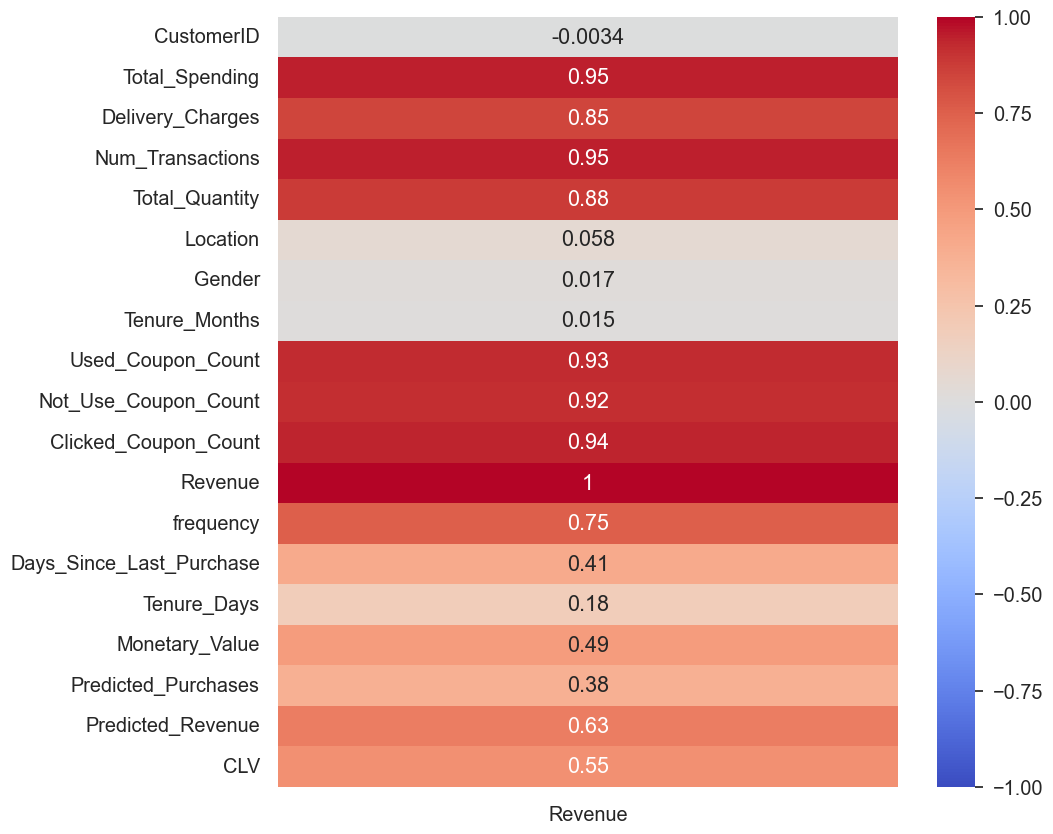

In [80]:
# Create a heatmap using Seaborn to visualize correlations between 'WnvPresent' and 'NumMosquitos' columns in the 'train_df' DataFrame
plt.figure(figsize=(10, 10))  # Set the size of the heatmap figure

# Use train_df.corr() to calculate the correlation matrix for numeric columns only and extract correlations with 'WnvPresent' and 'NumMosquitos'
# Create a heatmap with annotations showing correlation values
sns.heatmap(customer_analysis.corr(numeric_only=True)[['Revenue']], annot=True, vmin=-1, vmax=1, cmap="coolwarm")

sns.set(font_scale=1.3)  # Set the font scale for better readability of annotations

### Pre-processing: Filter out outliers

In [82]:
#rfm.to_csv('rfm.csv')
#customer_analysis.to_csv('customer_analysis_encoded.csv')